## Loan Approval Prediction using Machine Learning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import matplotlib.pylab as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pylab as plt

C:\Users\Anusia\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1. Data preprocessing and visualization

## 1.1. Import dataset, remove unnecessary columns

In [2]:
loan_data = pd.read_csv('Loan_data.csv', low_memory=False)

In [3]:
loan_data.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501        NaN     5000.0       5000.0           4975.0   36 months   
1  1077430        NaN     2500.0       2500.0           2500.0   60 months   
2  1077175        NaN     2400.0       2400.0           2400.0   36 months   
3  1076863        NaN    10000.0      10000.0          10000.0   36 months   
4  1075358        NaN     3000.0       3000.0           3000.0   60 months   

  int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0   10.65%       162.87     B        B2  ...                            NaN   
1   15.27%        59.83     C        C4  ...                            NaN   
2   15.96%        84.33     C        C5  ...                            NaN   
3   13.49%       339.31     C        C1  ...                            NaN   
4   12.69%        67.79     B        B5  ...                            NaN   

  hardship_last_payment_amount disbursement_method  debt_settlement_flag  \
0                          NaN                Cash                     N   
1                          NaN                Cash                     N   
2                          NaN                Cash                     N   
3                          NaN                Cash                     N   
4                          NaN                Cash                     N   

  debt_settlement_flag_date settlement_status settlement_date  \
0                       NaN               NaN             NaN   
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   
3                       NaN               NaN             NaN   
4                       NaN               NaN             NaN   

  settlement_amount settlement_percentage settlement_term  
0               NaN                   NaN             NaN  
1               NaN                   NaN             NaN  
2               NaN                   NaN             NaN  
3               NaN                   NaN             NaN  
4               NaN                   NaN             NaN  

[5 rows x 151 columns]

In [4]:
loan_data.shape

(42536, 151)

In [5]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42536 entries, 0 to 42535
Columns: 151 entries, id to settlement_term
dtypes: float64(120), object(31)
memory usage: 49.0+ MB


Dataset contain many columns so I will try to reduce it based on below parameters:
1) columns don't have data
2) columns with a small amount of data - less than 30%
3) columns containing data not known during the loan granting consideration
4) columns with only one value


In [6]:
#remove columns and rows with no data
loan_data = loan_data.dropna(axis=1, how='all')
loan_data = loan_data.dropna(axis=0, how='all')

In [7]:
loan_data.head()

id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
0  1077501     5000.0       5000.0           4975.0   36 months   10.65%   
1  1077430     2500.0       2500.0           2500.0   60 months   15.27%   
2  1077175     2400.0       2400.0           2400.0   36 months   15.96%   
3  1076863    10000.0      10000.0          10000.0   36 months   13.49%   
4  1075358     3000.0       3000.0           3000.0   60 months   12.69%   

   installment grade sub_grade                 emp_title  ... tax_liens  \
0       162.87     B        B2                       NaN  ...       0.0   
1        59.83     C        C4                     Ryder  ...       0.0   
2        84.33     C        C5                       NaN  ...       0.0   
3       339.31     C        C1       AIR RESOURCES BOARD  ...       0.0   
4        67.79     B        B5  University Medical Group  ...       0.0   

  hardship_flag  disbursement_method debt_settlement_flag  \
0             N                 Cash                    N   
1             N                 Cash                    N   
2             N                 Cash                    N   
3             N                 Cash                    N   
4             N                 Cash                    N   

  debt_settlement_flag_date settlement_status settlement_date  \
0                       NaN               NaN             NaN   
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   
3                       NaN               NaN             NaN   
4                       NaN               NaN             NaN   

  settlement_amount settlement_percentage settlement_term  
0               NaN                   NaN             NaN  
1               NaN                   NaN             NaN  
2               NaN                   NaN             NaN  
3               NaN                   NaN             NaN  
4               NaN                   NaN             NaN  

[5 rows x 69 columns]

In [8]:
loan_data.shape

(42536, 69)

In [9]:
#remove columns with a small amount of data - less than 30%
loan_data_30_count = len(loan_data) / 3
loan_data = loan_data.dropna(thresh=loan_data_30_count,axis=1)


In [10]:
loan_data.shape

(42536, 61)

In [11]:
#review name of the columns based on Dictionary and remove unnecessary columns for analyze 
loan_data_dictionary = pd.read_csv('LCDataDictionary.csv')
loan_data_dictionary.columns

#remove strange name of the columns
loan_data_dictionary = loan_data_dictionary.dropna(axis=1, how='all')
loan_data_dictionary.columns

#change name of the column for being more easier to understand
loan_data_dictionary = loan_data_dictionary.rename(columns={'LoanStatNew': 'Shortcut'})
loan_data_dictionary.head()

Shortcut                                        Description
0        acc_now_delinq  The number of accounts on which the borrower i...
1  acc_open_past_24mths         Number of trades opened in past 24 months.
2            addr_state  The state provided by the borrower in the loan...
3              all_util              Balance to credit limit on all trades
4            annual_inc  The self-reported annual income provided by th...

In [12]:
#join Disctionary with dataset
loan_data_dtypes = pd.DataFrame(loan_data.dtypes,columns=['dtypes'])
loan_data_dtypes = loan_data_dtypes.reset_index()
loan_data_dtypes['Shortcut'] = loan_data_dtypes['index']
loan_data_dtypes = loan_data_dtypes[['Shortcut','dtypes']]

loan_data_dtypes['first value'] = loan_data.loc[0].values
loan_data_preview = loan_data_dtypes.merge(loan_data_dictionary, on='Shortcut',how='left')
loan_data_preview.head()

Shortcut   dtypes first value  \
0               id   object     1077501   
1        loan_amnt  float64      5000.0   
2      funded_amnt  float64      5000.0   
3  funded_amnt_inv  float64      4975.0   
4             term   object   36 months   

                                         Description  
0      A unique LC assigned ID for the loan listing.  
1  The listed amount of the loan applied for by t...  
2  The total amount committed to that loan at tha...  
3  The total amount committed by investors for th...  
4  The number of payments on the loan. Values are...

In [13]:
#review remaining columns
loan_data_preview[:31]

Shortcut   dtypes  \
0                       id   object   
1                loan_amnt  float64   
2              funded_amnt  float64   
3          funded_amnt_inv  float64   
4                     term   object   
5                 int_rate   object   
6              installment  float64   
7                    grade   object   
8                sub_grade   object   
9                emp_title   object   
10              emp_length   object   
11          home_ownership   object   
12              annual_inc  float64   
13     verification_status   object   
14                 issue_d   object   
15             loan_status   object   
16              pymnt_plan   object   
17                     url   object   
18                    desc   object   
19                 purpose   object   
20                   title   object   
21                zip_code   object   
22              addr_state   object   
23                     dti  float64   
24             delinq_2yrs  float64   
25        earliest_cr_line   object   
26          fico_range_low  float64   
27         fico_range_high  float64   
28          inq_last_6mths  float64   
29  mths_since_last_delinq  float64   
30                open_acc  float64   

                                          first value  \
0                                             1077501   
1                                              5000.0   
2                                              5000.0   
3                                              4975.0   
4                                           36 months   
5                                              10.65%   
6                                              162.87   
7                                                   B   
8                                                  B2   
9                                                 NaN   
10                                          10+ years   
11                                               RENT   
12                                            24000.0   
13                                           Verified   
14                                           Dec-2011   
15                                         Fully Paid   
16                                                  n   
17  https://lendingclub.com/browse/loanDetail.acti...   
18    Borrower added on 12/22/11 > I need to upgra...   
19                                        credit_card   
20                                           Computer   
21                                              860xx   
22                                                 AZ   
23                                              27.65   
24                                                0.0   
25                                           Jan-1985   
26                                              735.0   
27                                              739.0   
28                                                1.0   
29                                                NaN   
30                                                3.0   

                                          Description  
0       A unique LC assigned ID for the loan listing.  
1   The listed amount of the loan applied for by t...  
2   The total amount committed to that loan at tha...  
3   The total amount committed by investors for th...  
4   The number of payments on the loan. Values are...  
5                           Interest Rate on the loan  
6   The monthly payment owed by the borrower if th...  
7                              LC assigned loan grade  
8                           LC assigned loan subgrade  
9   The job title supplied by the Borrower when ap...  
10  Employment length in years. Possible values ar...  
11  The home ownership status provided by the borr...  
12  The self-reported annual income provided by th...  
13  Indicates if income was verified by LC, not ve...  
14                The month which the loan was funded  
15                         Current status of the

In [14]:
loan_data_preview[31:]

Shortcut   dtypes  first value  \
31                     pub_rec  float64          0.0   
32                   revol_bal  float64      13648.0   
33                  revol_util   object        83.7%   
34                   total_acc  float64          9.0   
35         initial_list_status   object            f   
36                   out_prncp  float64          0.0   
37               out_prncp_inv  float64          0.0   
38                 total_pymnt  float64  5863.155187   
39             total_pymnt_inv  float64      5833.84   
40             total_rec_prncp  float64       5000.0   
41               total_rec_int  float64       863.16   
42          total_rec_late_fee  float64          0.0   
43                  recoveries  float64          0.0   
44     collection_recovery_fee  float64          0.0   
45                last_pymnt_d   object     Jan-2015   
46             last_pymnt_amnt  float64       171.62   
47          last_credit_pull_d   object     Aug-2018   
48        last_fico_range_high  float64        739.0   
49         last_fico_range_low  float64        735.0   
50  collections_12_mths_ex_med  float64          0.0   
51                 policy_code  float64          1.0   
52            application_type   object   Individual   
53              acc_now_delinq  float64          0.0   
54    chargeoff_within_12_mths  float64          0.0   
55                 delinq_amnt  float64          0.0   
56        pub_rec_bankruptcies  float64          0.0   
57                   tax_liens  float64          0.0   
58               hardship_flag   object            N   
59         disbursement_method   object         Cash   
60        debt_settlement_flag   object            N   

                                          Description  
31                Number of derogatory public records  
32                     Total credit revolving balance  
33  Revolving line utilization rate, or the amount...  
34  The total number of credit lines currently in ...  
35  The initial listing status of the loan. Possib...  
36  Remaining outstanding principal for total amou...  
37  Remaining outstanding principal for portion of...  
38  Payments received to date for total amount funded  
39  Payments received to date for portion of total...  
40                         Principal received to date  
41                          Interest received to date  
42                         Late fees received to date  
43                     post charge off gross recovery  
44                     post charge off collection fee  
45                    Last month payment was received  
46                 Last total payment amount received  
47  The most recent month LC pulled credit for thi...  
48  The upper boundary range the borrower’s last F...  
49  The lower boundary range the borrower’s last F...  
50  Number of collections in 12 months excluding m...  
51  publicly available policy_code=1\nnew products...  
52  Indicates whether the loan is an individual ap...  
53  The number of accounts on which the borrower i...  
54             Number of charge-offs within 12 months  
55  The past-due amount owed for the accounts on w...  
56               Number of public record bankruptcies  
57                                Number of tax liens  
58  Flags whether or not the borrower is on a hard...  
59  The method by which the borrower receives thei...  
60  Flags whether or not the borrower, who has cha...

Based on review below columns will be removed:


1) columns which don't have influence for decistion about loan(text): id, url, emp_title, zip_code, issue_d, hardship_flag, int_rate

2) columns with data about the future : funded_amnt, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt

3) sub_grade - information about grade will be sufficient

In [15]:
drop_columns = ['id','url', 'int_rate','emp_title', 'desc','issue_d','zip_code', 'funded_amnt', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'sub_grade', 'hardship_flag']
loan_data = loan_data.drop(drop_columns, axis=1)

In [16]:
#removing columns with one type of data
loan_data = loan_data.loc[:,loan_data.apply(pd.Series.nunique) != 1]

In [17]:
#removing columns where unique values are only 5 and less

for col in loan_data.columns:
    if (len(loan_data[col].unique()) < 5):
        print(loan_data[col].value_counts())
        print()

 36 months    31534
 60 months    11001
Name: term, dtype: int64

Not Verified       18758
Verified           13471
Source Verified    10306
Name: verification_status, dtype: int64

0.0    42502
1.0        4
Name: acc_now_delinq, dtype: int64

0.0       42504
27.0          1
6053.0        1
Name: delinq_amnt, dtype: int64

0.0    39316
1.0     1846
2.0        8
Name: pub_rec_bankruptcies, dtype: int64

0.0    42429
1.0        1
Name: tax_liens, dtype: int64

N    42375
Y      160
Name: debt_settlement_flag, dtype: int64



In [18]:
# columns tax_liens, delinq_amnt have only one type of unique value and acc_now_delinq has only 4 so we can remove it
drop_columns2 = ['tax_liens', 'delinq_amnt', 'acc_now_delinq']
loan_data = loan_data.drop(drop_columns2, axis=1)

In [19]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42536 entries, 0 to 42535
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               42535 non-null  float64
 1   funded_amnt_inv         42535 non-null  float64
 2   term                    42535 non-null  object 
 3   installment             42535 non-null  float64
 4   grade                   42535 non-null  object 
 5   emp_length              41423 non-null  object 
 6   home_ownership          42535 non-null  object 
 7   annual_inc              42531 non-null  float64
 8   verification_status     42535 non-null  object 
 9   loan_status             42535 non-null  object 
 10  purpose                 42535 non-null  object 
 11  title                   42522 non-null  object 
 12  addr_state              42535 non-null  object 
 13  dti                     42535 non-null  float64
 14  delinq_2yrs             42506 non-null

## 1.2. Review the value in column "Loan Status" 

In [20]:
#reviewing type of date in Loan Status column
loan_data["loan_status"].value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

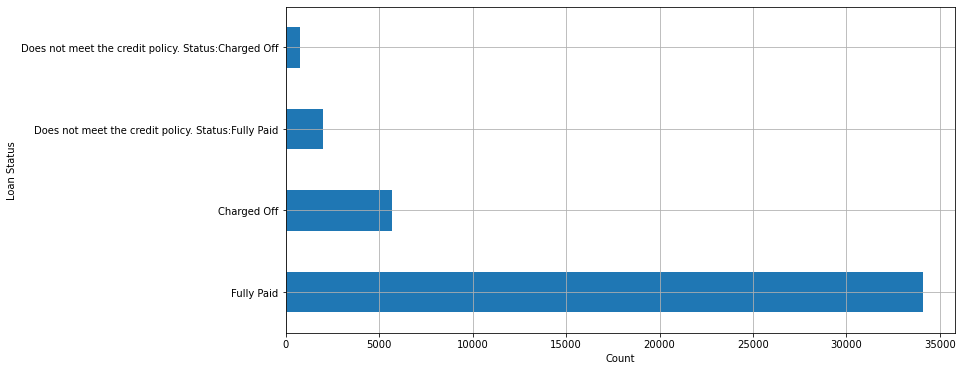

In [21]:
#presenting data on the chart
plt.figure(figsize= (12,6))
plt.ylabel('Loan Status')
plt.xlabel('Count')
loan_data['loan_status'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

There are 4 types of loan statuses: fully paid, charged off, Does not meet the credit policy. Status: Fully Paid, Does not meet he credit policy. Status: Charged Off

Due to the fact that the main variables are charged off and fully paid, they will be included to them accordingly: "Does not meet the credit policy. Status: Fully Paid", "Does not meet he credit policy. Status: Charged Off"

In [22]:
#changing the data
loan_data['loan_status'].replace(['Does not meet the credit policy. Status:Fully Paid'],'Fully Paid')
loan_data['loan_status'] = loan_data['loan_status'].replace(['Does not meet the credit policy. Status:Fully Paid'],'Fully Paid')

In [23]:
loan_data['loan_status'].replace(['Does not meet the credit policy. Status:Charged Off'],'Charged Off')


0         Fully Paid
1        Charged Off
2         Fully Paid
3         Fully Paid
4         Fully Paid
            ...     
42531     Fully Paid
42532     Fully Paid
42533     Fully Paid
42534     Fully Paid
42535     Fully Paid
Name: loan_status, Length: 42536, dtype: object

In [24]:
loan_data['loan_status'] = loan_data['loan_status'].replace(['Does not meet the credit policy. Status:Charged Off'],'Charged Off')

In [25]:
loan_data["loan_status"].value_counts()

Fully Paid     36104
Charged Off     6431
Name: loan_status, dtype: int64

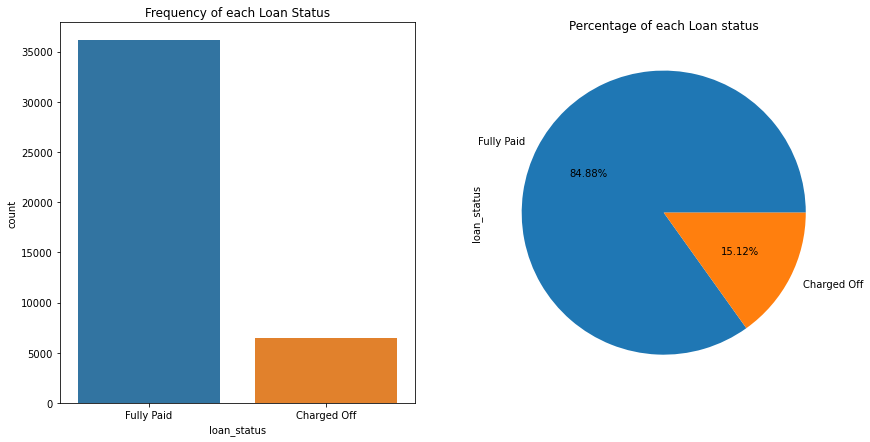

In [26]:
#presentation final outcome
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='loan_status',data=loan_data,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
loan_data.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()

The data is not balansed. Most loans are fully paid off. 

In [27]:
#label encoding
loan_data = loan_data[(loan_data["loan_status"] == "Fully Paid") |
                            (loan_data["loan_status"] == "Charged Off")]

loan_data_mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0}}
loan_data = loan_data.replace(loan_data_mapping_dictionary)

## 1.3. Convert values in columns

In [28]:
#data types and their frequency
print("Data types and their frequency\n{}".format(loan_data.dtypes.value_counts()))

Data types and their frequency
float64    17
object     12
int64       1
dtype: int64


In [29]:
# we have 14 objects, so it's worth taking a closer look at them and try to convert them into numbers and remove unnecessary data
loan_data_objects = loan_data.select_dtypes(include=['object'])
print(loan_data_objects.iloc[0])


term                      36 months
grade                             B
emp_length                10+ years
home_ownership                 RENT
verification_status        Verified
purpose                 credit_card
title                      Computer
addr_state                       AZ
earliest_cr_line           Jan-1985
revol_util                    83.7%
last_credit_pull_d         Aug-2018
debt_settlement_flag              N
Name: 0, dtype: object


In [30]:
#columns term - since there are only two options, the data will be changed from string to intiger
loan_data['term'].value_counts()

 36 months    31534
 60 months    11001
Name: term, dtype: int64

In [31]:
loan_data['term'] = loan_data['term'].replace([' 36 months'], 36)
loan_data['term'] = loan_data['term'].replace([' 60 months'], 60)

In [32]:
#changing name of the column for beeaing more understandable
loan_data = loan_data.rename(columns={"term": "term_in_months"})

In [33]:
loan_data['term_in_months'].value_counts()

36    31534
60    11001
Name: term_in_months, dtype: int64

Columns: grade, emp_lenght, verification_status, home_ownership, purpose, title, addr_state represent categories. I will check it.

Columns earliest_cr_line last_credit_pull_d they seems like date with many different values.

Columns purpose i title seems to have many different values which don't necessarily overlap



In [34]:
#checking the distribution and amount of data in individual categories
loan_data_category_check = ['home_ownership','verification_status', 'emp_length', 'term', 'addr_state']
for name in loan_data_category_check:
    print(name,':')
    print(loan_data_objects[name].value_counts(),'\n')

home_ownership :
RENT        20181
MORTGAGE    18959
OWN          3251
OTHER         136
NONE            8
Name: home_ownership, dtype: int64 

verification_status :
Not Verified       18758
Verified           13471
Source Verified    10306
Name: verification_status, dtype: int64 

emp_length :
10+ years    9369
< 1 year     5062
2 years      4743
3 years      4364
4 years      3649
1 year       3595
5 years      3458
6 years      2375
7 years      1875
8 years      1592
9 years      1341
Name: emp_length, dtype: int64 

term :
 36 months    31534
 60 months    11001
Name: term, dtype: int64 

addr_state :
CA    7429
NY    4065
FL    3104
TX    2915
NJ    1988
IL    1672
PA    1651
GA    1503
VA    1487
MA    1438
OH    1329
MD    1125
AZ     933
WA     888
CO     857
NC     830
CT     816
MI     796
MO     765
MN     652
NV     527
WI     516
SC     489
AL     484
OR     468
LA     461
KY     359
OK     317
KS     298
UT     278
AR     261
DC     224
RI     208
NM     205
NH     188
W

I will reject column addr_state column whose data can be assigned to multiple categories. This will not affect the quality of the data. The rest of the data can be encoded as dummy.


In [35]:
# columns revol_until - changing % to float
loan_data['revol_util'] = loan_data['revol_util'].str.rstrip('%').astype('float')

In [36]:
loan_data['revol_util'].value_counts()

0.00      1070
40.70       65
0.20        64
63.00       63
66.60       62
          ... 
21.59        1
39.95        1
0.01         1
17.67        1
105.70       1
Name: revol_util, Length: 1119, dtype: int64

In [37]:
#review colums earliest_cr_line last_credit_pull_d
for name in ['earliest_cr_line','last_credit_pull_d']:
    print("Unique Values in column: {}\n".format(name))
    print(loan_data[name].value_counts(),'\n')

Unique Values in column: earliest_cr_line

Oct-1999    393
Nov-1998    390
Oct-2000    370
Dec-1998    366
Dec-1997    348
           ... 
Jul-1964      1
Mar-1963      1
Nov-1965      1
Apr-1966      1
Nov-1959      1
Name: earliest_cr_line, Length: 530, dtype: int64 

Unique Values in column: last_credit_pull_d

Aug-2018    9248
Oct-2016    4071
Jul-2018    1233
May-2018     734
Feb-2017     709
            ... 
Feb-2008       2
Dec-2007       2
Jun-2008       1
Jul-2008       1
Jul-2007       1
Name: last_credit_pull_d, Length: 133, dtype: int64 



The columns contain a lot of different values and will not be useful for further analysis.

In [38]:
#reviwing columns puprose i title
for name in ['purpose','title']:
    print("Unique Values in column: {}\n".format(name))
    print(loan_data[name].value_counts(),'\n')

Unique Values in column: purpose

debt_consolidation    19776
credit_card            5477
other                  4425
home_improvement       3199
major_purchase         2311
small_business         1992
car                    1615
wedding                1004
medical                 753
moving                  629
house                   426
educational             422
vacation                400
renewable_energy        106
Name: purpose, dtype: int64 

Unique Values in column: title

Debt Consolidation                  2259
Debt Consolidation Loan             1760
Personal Loan                        708
Consolidation                        547
debt consolidation                   532
                                    ... 
CitiCard PayOff                        1
Taxes Loan                             1
Blazing in 5 years                     1
I was scammed and now recovering       1
Aroundthehouse                         1
Name: title, Length: 21264, dtype: int64 



The purpose and title columns contain data that overlap. The title column contains more diverse categories and therefore could be excluded from the analysis.

In [39]:
#removing columns
drop_cols1 = ['last_credit_pull_d','addr_state','title','earliest_cr_line']
loan_data = loan_data.drop(drop_cols1,axis=1)

In [40]:
loan_data.head()

loan_amnt  funded_amnt_inv  term_in_months  installment grade emp_length  \
0     5000.0           4975.0              36       162.87     B  10+ years   
1     2500.0           2500.0              60        59.83     C   < 1 year   
2     2400.0           2400.0              36        84.33     C  10+ years   
3    10000.0          10000.0              36       339.31     C  10+ years   
4     3000.0           3000.0              60        67.79     B     1 year   

  home_ownership  annual_inc verification_status  loan_status  ...  \
0           RENT     24000.0            Verified            1  ...   
1           RENT     30000.0     Source Verified            0  ...   
2           RENT     12252.0        Not Verified            1  ...   
3           RENT     49200.0     Source Verified            1  ...   
4           RENT     80000.0     Source Verified            1  ...   

  mths_since_last_delinq  open_acc  pub_rec  revol_bal  revol_util  total_acc  \
0                    NaN       3.0      0.0    13648.0        83.7        9.0   
1                    NaN       3.0      0.0     1687.0         9.4        4.0   
2                    NaN       2.0      0.0     2956.0        98.5       10.0   
3                   35.0      10.0      0.0     5598.0        21.0       37.0   
4                   38.0      15.0      0.0    27783.0        53.9       38.0   

   last_fico_range_high  last_fico_range_low  pub_rec_bankruptcies  \
0                 739.0                735.0                   0.0   
1                 499.0                  0.0                   0.0   
2                 739.0                735.0                   0.0   
3                 604.0                600.0                   0.0   
4                 684.0                680.0                   0.0   

   debt_settlement_flag  
0                     N  
1                     N  
2                     N  
3                     N  
4                     N  

[5 rows x 26 columns]

Based on the column overview, it can be concluded that two categorical values can be arranged in ascending / descending order: emp_length and grade (we assume that grade A is the least risky and G the most risky).

In [41]:
#ordering columns emp_length and grade
loan_data_mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0

    },
    "grade":{
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
        "E": 5,
        "F": 6,
        "G": 7
    }
}

loan_data = loan_data.replace(loan_data_mapping_dict)
loan_data[['emp_length','grade']].head()

emp_length  grade
0        10.0      2
1         0.0      3
2        10.0      3
3        10.0      3
4         1.0      2

## 1.4. Analyze missing value

In [42]:
loan_data[loan_data['emp_length'].isnull()]

loan_amnt  funded_amnt_inv  term_in_months  installment  grade  \
168       2500.0      2500.000000              36        77.78      1   
323      18000.0     18000.000000              60       452.98      4   
394       4000.0      4000.000000              36       132.31      2   
422       1000.0      1000.000000              36        34.50      3   
439       8250.0      8250.000000              36       256.67      1   
...          ...              ...             ...          ...    ...   
40583     5000.0      5000.000000              36       168.73      3   
40667    14500.0     11624.997997              36       551.08      7   
40672     3700.0      3600.000000              36       115.74      1   
40697     3250.0      3250.000000              36       114.38      4   
40731     3600.0      3575.000000              36       121.08      3   

       emp_length home_ownership  annual_inc verification_status  loan_status  \
168           NaN            OWN     12000.0     Source Verified            0   
323           NaN       MORTGAGE     60000.0            Verified            1   
394           NaN           RENT     24000.0     Source Verified            1   
422           NaN           RENT     18408.0        Not Verified            0   
439           NaN       MORTGAGE     31500.0            Verified            1   
...           ...            ...         ...                 ...          ...   
40583         NaN           RENT     55260.0        Not Verified            0   
40667         NaN           RENT     60000.0            Verified            0   
40672         NaN       MORTGAGE     59820.0        Not Verified            1   
40697         NaN       MORTGAGE     42192.0        Not Verified            1   
40731         NaN           RENT     24000.0        Not Verified            1   

       ... mths_since_last_delinq  open_acc  pub_rec  revol_bal  revol_util  \
168    ...                    NaN      13.0      0.0     4853.0        42.2   
323    ...                   75.0      11.0      0.0     5945.0        83.7   
394    ...                   16.0       4.0      0.0     1593.0        54.9   
422    ...                    NaN       3.0      1.0     2510.0        83.7   
439    ...                    NaN      17.0      0.0     7521.0        10.4   
...    ...                    ...       ...      ...        ...         ...   
40583  ...                    NaN       6.0      0.0     1871.0        60.4   
40667  ...                    NaN      11.0      0.0    16441.0        49.8   
40672  ...                    NaN       6.0      0.0    11586.0        61.6   
40697  ...                   41.0      13.0      1.0    11854.0        71.9   
40731  ...                    NaN       8.0      0.0     2650.0        26.2   

       total_acc  last_fico_range_high  last_fico_range_low  \
168         20.0                 539.0                535.0   
323         28.0                 664.0                660.0   
394          6.0                 664.0                660.0   
422          8.0                 499.0                  0.0   
439         37.0                 684.0                680.0   
...          ...                   ...                  ...   
40583       10.0                 594.0                590.0   
40667       23.0                 679.0                675.0   
40672        9.0                 784.0                780.0   
40697       20.0                 689.0                685.0   
40731       12.0                 659.0                655.0   

       pub_rec_bankruptcies  debt_settlement_flag  
168                     0.0                     N  
323                     0.0                     N  
394                     0.0                     N  
422                     1.0                     N  
439                     0.0                     N  
...                     ...                   ...  
40583                   0.0                     N  
40667                   0.0        

In [43]:
#checking missing values in columns
loan_data_null_counts = loan_data.isnull().sum()
print("Number of null values in each column:\n{}".format(loan_data_null_counts))

Number of null values in each column:
loan_amnt                     0
funded_amnt_inv               0
term_in_months                0
installment                   0
grade                         0
emp_length                 1112
home_ownership                0
annual_inc                    4
verification_status           0
loan_status                   0
purpose                       0
dti                           0
delinq_2yrs                  29
fico_range_low                0
fico_range_high               0
inq_last_6mths               29
mths_since_last_delinq    26926
open_acc                     29
pub_rec                      29
revol_bal                     0
revol_util                   90
total_acc                    29
last_fico_range_high          0
last_fico_range_low           0
pub_rec_bankruptcies       1365
debt_settlement_flag          0
dtype: int64


Below columns have missing values:

emp_length,annual_inc, delinq_2yrs,inq_last_6mths, mths_since_last_delinq ,open_acc, pub_rec, revol_util, total_acc, pub_rec_bankruptcies

In [44]:
#more detailed information about column emp_length.
loan_data_preview[(loan_data_preview.Shortcut == 'emp_length')]

Shortcut  dtypes first value  \
10  emp_length  object   10+ years   

                                          Description  
10  Employment length in years. Possible values ar...

In [45]:
#review categories of column delinq_2years
loan_data['delinq_2yrs'].value_counts()

0.0     37771
1.0      3595
2.0       771
3.0       244
4.0        72
5.0        27
6.0        13
7.0         6
8.0         3
11.0        2
9.0         1
13.0        1
Name: delinq_2yrs, dtype: int64

In [46]:
#review categories of column inq_last_6mths
loan_data['inq_last_6mths'].value_counts()

0.0     19657
1.0     11247
2.0      5987
3.0      3182
4.0      1056
5.0       596
6.0       339
7.0       182
8.0       115
9.0        50
10.0       24
11.0       15
12.0       15
15.0        9
13.0        6
14.0        6
18.0        4
16.0        3
17.0        2
24.0        2
19.0        2
32.0        1
33.0        1
31.0        1
28.0        1
25.0        1
27.0        1
20.0        1
Name: inq_last_6mths, dtype: int64

In [47]:
#review categories of column open_acc
loan_data['open_acc'].value_counts()

7.0     4252
8.0     4176
6.0     4172
9.0     3922
10.0    3386
5.0     3368
11.0    2944
4.0     2508
12.0    2398
13.0    2060
3.0     1608
14.0    1597
15.0    1290
16.0    1022
17.0     812
2.0      692
18.0     588
19.0     442
20.0     335
21.0     276
22.0     170
23.0     121
24.0      87
25.0      63
26.0      40
1.0       39
27.0      29
28.0      29
30.0      17
29.0      16
31.0      13
34.0       8
32.0       6
33.0       5
35.0       4
36.0       2
38.0       2
37.0       1
46.0       1
39.0       1
42.0       1
41.0       1
44.0       1
47.0       1
Name: open_acc, dtype: int64

In [48]:
#review categories of column pub_rec
loan_data['pub_rec'].value_counts()

0.0    40130
1.0     2298
2.0       64
3.0       11
4.0        2
5.0        1
Name: pub_rec, dtype: int64

In [49]:
#review categories of column revol_util
loan_data['revol_util'].value_counts()

0.00      1070
40.70       65
0.20        64
63.00       63
66.60       62
          ... 
21.59        1
39.95        1
0.01         1
17.67        1
105.70       1
Name: revol_util, Length: 1119, dtype: int64

In [50]:
#review categories of column total_acc
loan_data['total_acc'].value_counts()

15.0    1552
16.0    1547
17.0    1543
14.0    1531
20.0    1504
        ... 
74.0       1
77.0       1
78.0       1
72.0       1
90.0       1
Name: total_acc, Length: 83, dtype: int64

In [51]:
#review categories of column pub_rec_bankruptcies
loan_data['pub_rec_bankruptcies'].value_counts()

0.0    39316
1.0     1846
2.0        8
Name: pub_rec_bankruptcies, dtype: int64

Based on the analysis, the following activities will be performed to supplement the missing data:

1) emp_length -  no data means that someone is not working, so we assign a value of 0

2) annual_inc,open_acc, total_acc - the amount of missing data is less than 1% and the data varies so the rows will be removed

3) mths_since_last_delinq - missing data is over 50% - we remove the column

4) delinq_2yrs,inq_last_6mths,pub_rec,revol_util,pub_rec_bankruptcies - the number of missing values is less than 1%, therefore they will be assigned to the most common values


In [52]:
loan_data['emp_length'] = loan_data['emp_length'].fillna(0)

In [53]:
loan_data['delinq_2yrs'] = loan_data['delinq_2yrs'].fillna(0)

In [54]:
loan_data['inq_last_6mths'] = loan_data['inq_last_6mths'].fillna(0)

In [55]:
loan_data['pub_rec'] = loan_data['pub_rec'].fillna(0)

In [56]:
loan_data['revol_util'] = loan_data['revol_util'].fillna(0)

In [57]:
loan_data['pub_rec_bankruptcies'] = loan_data['pub_rec_bankruptcies'].fillna(0)

In [58]:
drop_cols2 = ['mths_since_last_delinq']
loan_data = loan_data.drop(drop_cols2,axis=1)

In [59]:
loan_data = loan_data.dropna()

In [60]:
#checking n/a
loan_data_null_counts = loan_data.isnull().sum()
print("Number of null values in each column:\n{}".format(loan_data_null_counts))

Number of null values in each column:
loan_amnt               0
funded_amnt_inv         0
term_in_months          0
installment             0
grade                   0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
dti                     0
delinq_2yrs             0
fico_range_low          0
fico_range_high         0
inq_last_6mths          0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
last_fico_range_high    0
last_fico_range_low     0
pub_rec_bankruptcies    0
debt_settlement_flag    0
dtype: int64


# 2. Data analysis

In [61]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42506 entries, 0 to 42514
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             42506 non-null  float64
 1   funded_amnt_inv       42506 non-null  float64
 2   term_in_months        42506 non-null  int64  
 3   installment           42506 non-null  float64
 4   grade                 42506 non-null  int64  
 5   emp_length            42506 non-null  float64
 6   home_ownership        42506 non-null  object 
 7   annual_inc            42506 non-null  float64
 8   verification_status   42506 non-null  object 
 9   loan_status           42506 non-null  int64  
 10  purpose               42506 non-null  object 
 11  dti                   42506 non-null  float64
 12  delinq_2yrs           42506 non-null  float64
 13  fico_range_low        42506 non-null  float64
 14  fico_range_high       42506 non-null  float64
 15  inq_last_6mths     

In [62]:
loan_data.describe().T

count          mean           std      min       25%  \
loan_amnt             42506.0  11094.625465   7410.835576   500.00   5200.00   
funded_amnt_inv       42506.0  10146.285141   7129.794024     0.00   4950.00   
term_in_months        42506.0     42.211453     10.511675    36.00     36.00   
installment           42506.0    322.759750    208.924211    15.67    165.67   
grade                 42506.0      2.671317      1.438566     1.00      2.00   
emp_length            42506.0      4.796335      3.607544     0.00      2.00   
annual_inc            42506.0  69135.339884  64096.039777  1896.00  40000.00   
loan_status           42506.0      0.848774      0.358273     0.00      1.00   
dti                   42506.0     13.376882      6.725965     0.00      8.20   
delinq_2yrs           42506.0      0.152449      0.512406     0.00      0.00   
fico_range_low        42506.0    713.044982     36.182005   610.00    685.00   
fico_range_high       42506.0    717.044982     36.182005   614.00    689.00   
inq_last_6mths        42506.0      1.081424      1.527455     0.00      0.00   
open_acc              42506.0      9.343951      4.496274     1.00      6.00   
pub_rec               42506.0      0.058156      0.245713     0.00      0.00   
revol_bal             42506.0  14307.615725  22022.782452     0.00   3646.00   
revol_util            42506.0     49.046668     28.404834     0.00     25.60   
total_acc             42506.0     22.124406     11.592811     1.00     13.00   
last_fico_range_high  42506.0    689.932410     80.748336     0.00    644.00   
last_fico_range_low   42506.0    676.955724    119.623888     0.00    640.00   
pub_rec_bankruptcies  42506.0      0.043806      0.205582     0.00      0.00   

                           50%        75%         max  
loan_amnt              9750.00  15000.000    35000.00  
funded_amnt_inv        8500.00  14000.000    35000.00  
term_in_months           36.00     60.000       60.00  
installment             277.86    428.500     1305.19  
grade                     2.00      4.000        7.00  
emp_length                4.00      9.000       10.00  
annual_inc            59000.00  82485.000  6000000.00  
loan_status               1.00      1.000        1.00  
dti                      13.48     18.680       29.99  
delinq_2yrs               0.00      0.000       13.00  
fico_range_low          710.00    740.000      825.00  
fico_range_high         714.00    744.000      829.00  
inq_last_6mths            1.00      2.000       33.00  
open_acc                  9.00     12.000       47.00  
pub_rec                   0.00      0.000        5.00  
revol_bal              8829.50  17258.000  1207359.00  
revol_util               49.60     72.675      119.00  
total_acc                20.00     29.000       90.00  
last_fico_range_high    699.00    749.000      850.00  
last_fico_range_low     695.00    745.000      845.00  
pub_rec_bankruptcies      0.00      0.000        2.00

array([[<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt_inv'}>,
        <AxesSubplot:title={'center':'term_in_months'}>,
        <AxesSubplot:title={'center':'installment'}>,
        <AxesSubplot:title={'center':'grade'}>],
       [<AxesSubplot:title={'center':'emp_length'}>,
        <AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'loan_status'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>],
       [<AxesSubplot:title={'center':'fico_range_low'}>,
        <AxesSubplot:title={'center':'fico_range_high'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'open_acc'}>,
        <AxesSubplot:title={'center':'pub_rec'}>],
       [<AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'revol_util'}>,
        <AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'center':'

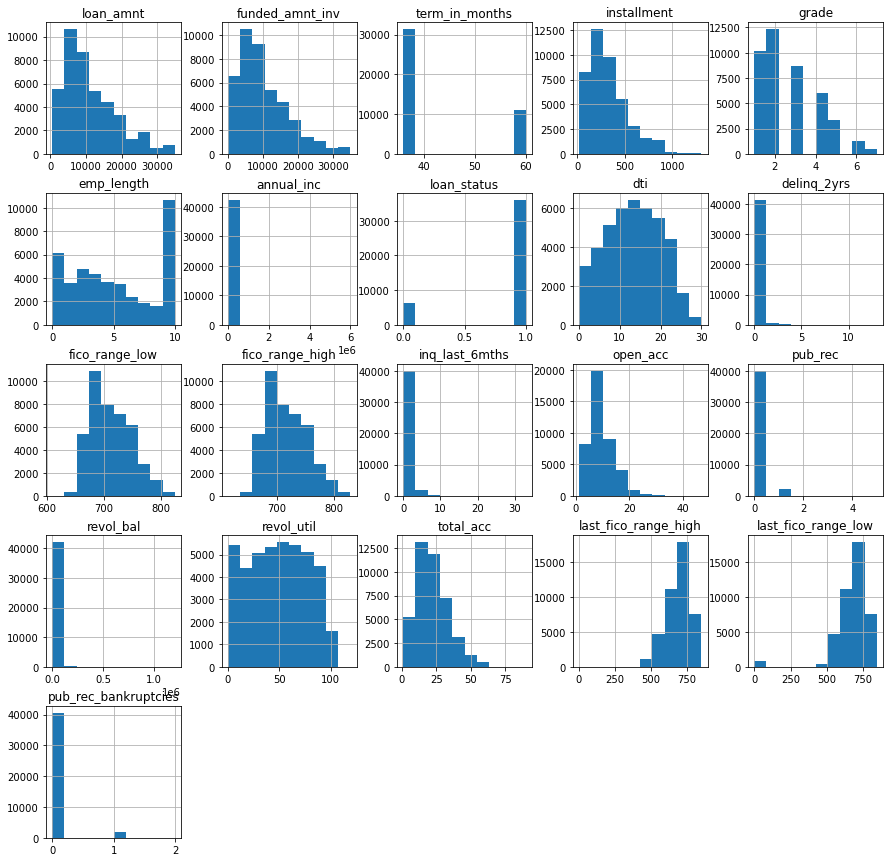

In [63]:
#reviwing data
loan_data.hist(figsize=(15,15))

In [64]:
#convert the remaining columns to numeric values using the dummies function
loan_data_nominal_columns = ["home_ownership", "verification_status", "purpose", 'debt_settlement_flag']
loan_data_dummy = pd.get_dummies(loan_data[loan_data_nominal_columns])
loan_data_dummy = pd.concat([loan_data, loan_data_dummy], axis=1)
loan_data_dummy = loan_data_dummy.drop(loan_data_nominal_columns, axis=1)
loan_data_dummy.head()

loan_amnt  funded_amnt_inv  term_in_months  installment  grade  emp_length  \
0     5000.0           4975.0              36       162.87      2        10.0   
1     2500.0           2500.0              60        59.83      3         0.0   
2     2400.0           2400.0              36        84.33      3        10.0   
3    10000.0          10000.0              36       339.31      3        10.0   
4     3000.0           3000.0              60        67.79      2         1.0   

   annual_inc  loan_status    dti  delinq_2yrs  ...  purpose_major_purchase  \
0     24000.0            1  27.65          0.0  ...                       0   
1     30000.0            0   1.00          0.0  ...                       0   
2     12252.0            1   8.72          0.0  ...                       0   
3     49200.0            1  20.00          0.0  ...                       0   
4     80000.0            1  17.94          0.0  ...                       0   

   purpose_medical  purpose_moving  purpose_other  purpose_renewable_energy  \
0                0               0              0                         0   
1                0               0              0                         0   
2                0               0              0                         0   
3                0               0              1                         0   
4                0               0              1                         0   

   purpose_small_business  purpose_vacation  purpose_wedding  \
0                       0                 0                0   
1                       0                 0                0   
2                       1                 0                0   
3                       0                 0                0   
4                       0                 0                0   

   debt_settlement_flag_N  debt_settlement_flag_Y  
0                       1                       0  
1                       1                       0  
2                       1                       0  
3                       1                       0  
4                       1                       0  

[5 rows x 45 columns]

## 2.1. Data correlation analysis

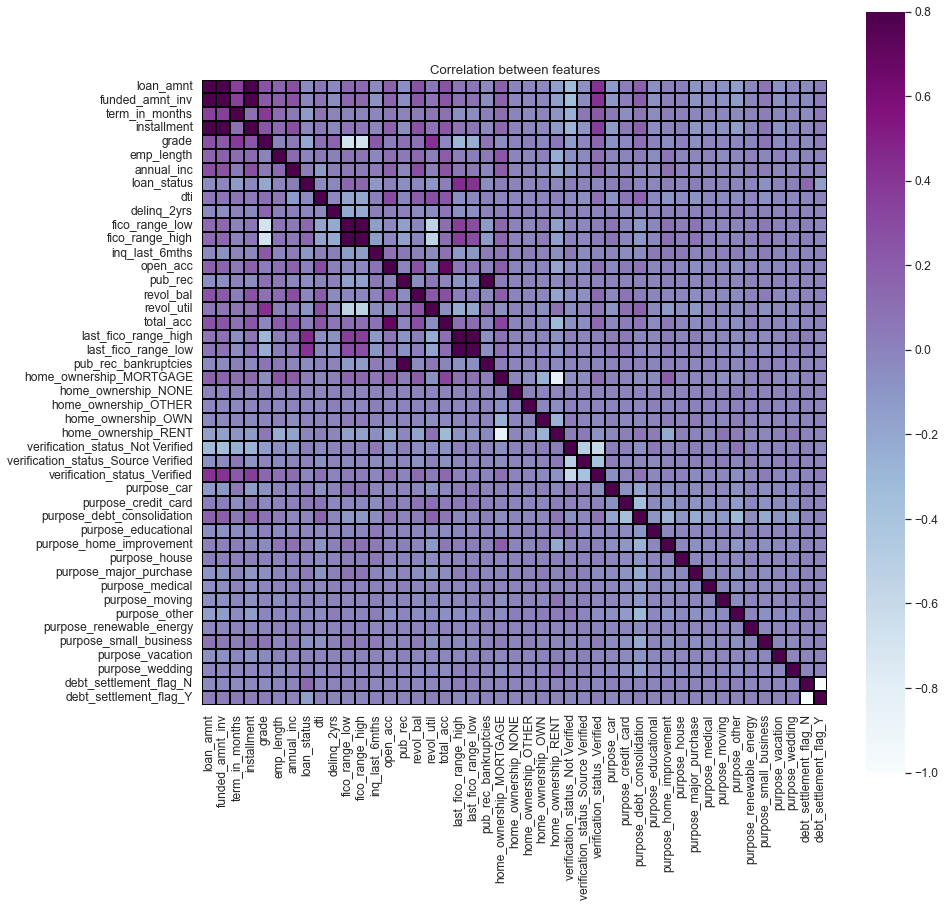

In [65]:
#review of the correlation between the variables
loan_data_cor=loan_data_dummy.corr()


sns.set(font_scale=1.10)
plt.figure(figsize=(14, 14))

sns.heatmap(loan_data_cor, vmax=.8, linewidths=0.01,
            square=True,annot=False,cmap="BuPu",linecolor="black")
plt.title('Correlation between features');

At first glance, you can see that the purpose columns have the smallest correlation. For better clarity, a heatmap will be generated showing the correlations without the credit target variables.

In [66]:
drop_cols3 = ['purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding']
loan_data_no_purpose = loan_data_dummy.drop(drop_cols3,axis=1)

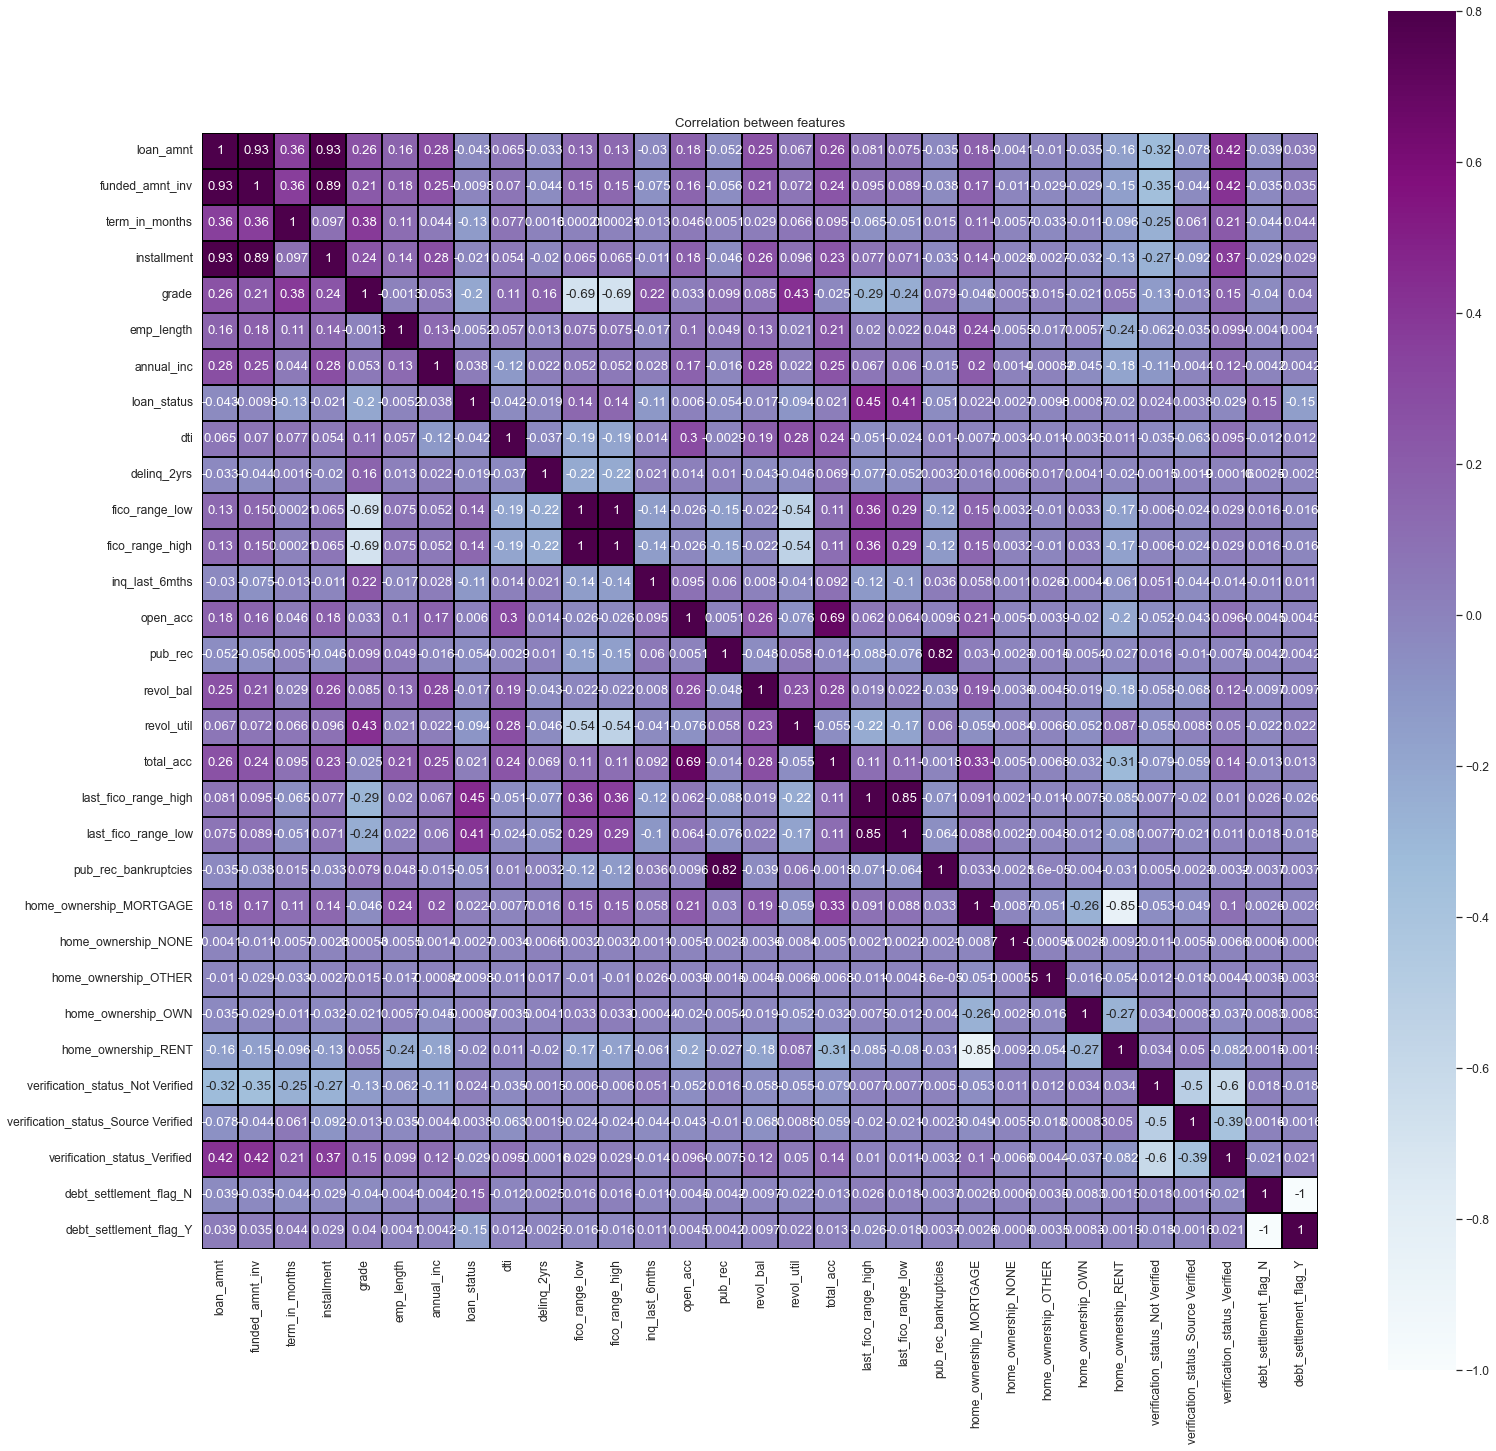

In [67]:
#correlation analysis without data related to the purpose of the loan
loan_data_dummy_cor=loan_data_no_purpose.corr()


sns.set(font_scale=1.10)
plt.figure(figsize=(25, 25))

sns.heatmap(loan_data_dummy_cor, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap="BuPu",linecolor="black")
plt.title('Correlation between features');

The variables last_fico_range high and last_fico_range_low have the greatest impact on whether the loan can be potentially repaid.

In the analyzed data set there are explanatory variables that are highly correlated with each other, therefore one of them should be removed:
- funded_amnt_inv z loan_amount (the total amount taken by investors up to the value of the requested loan) - remove funded_amnt_inv
- loan amount z installment (value of the requested loan up to the monthly payment in installments) - remove installement
- installment z funded_amnt_inv (the value of monthly installment payments up to the total amount borrowed by borrowers) one will be removed due to previous correlations
- pub_rec z pub_rec_bankruptcies (unpaid financial liabilities up to the number of registered debts) - remove pub_rec_bankruptcies
- last_fico_range_high z last_fico_range_low (the lower and upper bounds of the range to which the last FICO calculation belongs) - subject to a more detailed analysis due to the fact that they have an impact on whether the loan can be repaid


In [68]:
loan_data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42506 entries, 0 to 42514
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            42506 non-null  float64
 1   funded_amnt_inv                      42506 non-null  float64
 2   term_in_months                       42506 non-null  int64  
 3   installment                          42506 non-null  float64
 4   grade                                42506 non-null  int64  
 5   emp_length                           42506 non-null  float64
 6   annual_inc                           42506 non-null  float64
 7   loan_status                          42506 non-null  int64  
 8   dti                                  42506 non-null  float64
 9   delinq_2yrs                          42506 non-null  float64
 10  fico_range_low                       42506 non-null  float64
 11  fico_range_high             

In [69]:
#removing columns that are highly correlated with each other
drop_cols4 = ['funded_amnt_inv','installment','pub_rec_bankruptcies']
loan_data_dummy = loan_data_dummy.drop(drop_cols4,axis=1)

In [70]:
loan_data_dummy

loan_amnt  term_in_months  grade  emp_length  annual_inc  loan_status  \
0         5000.0              36      2        10.0     24000.0            1   
1         2500.0              60      3         0.0     30000.0            0   
2         2400.0              36      3        10.0     12252.0            1   
3        10000.0              36      3        10.0     49200.0            1   
4         3000.0              60      2         1.0     80000.0            1   
...          ...             ...    ...         ...         ...          ...   
42509     5350.0              36      4         1.0      4000.0            1   
42511    10000.0              36      5         1.0     50000.0            1   
42512     2000.0              36      1         7.0    150000.0            1   
42513     6000.0              36      3         0.0     20000.0            1   
42514     4400.0              36      2         2.0     30000.0            1   

         dti  delinq_2yrs  fico_range_low  fico_range_high  ...  \
0      27.65          0.0           735.0            739.0  ...   
1       1.00          0.0           740.0            744.0  ...   
2       8.72          0.0           735.0            739.0  ...   
3      20.00          0.0           690.0            694.0  ...   
4      17.94          0.0           695.0            699.0  ...   
...      ...          ...             ...              ...  ...   
42509  15.00          0.0           660.0            664.0  ...   
42511   7.22          2.0           650.0            654.0  ...   
42512   5.60          0.0           800.0            804.0  ...   
42513  12.90          0.0           695.0            699.0  ...   
42514   3.72          0.0           695.0            699.0  ...   

       purpose_major_purchase  purpose_medical  purpose_moving  purpose_other  \
0                           0                0               0              0   
1                           0                0               0              0   
2                           0                0               0              0   
3                           0                0               0              1   
4                           0                0               0              1   
...                       ...              ...             ...            ...   
42509                       0                0               0              0   
42511                       0                0               0              0   
42512                       0                0               0              0   
42513                       0                0               0              0   
42514                       0                0               0              0   

       purpose_renewable_energy  purpose_small_business  purpose_vacation  \
0                             0                       0                 0   
1                             0                       0                 0   
2                             0                       1                 0   
3                             0                       0                 0   
4                             0                       0                 0   
...                         ...                     ...               ...   
42509                         0                       0                 0   
42511                         0                       0                 0   
42512                         0                       0                 0   
42513                         0                       0                 0   
42514                         0                       0                 0   

       purpose_wedding  debt_settlement_flag_N  debt_settlement_flag_Y  
0                    0                       1                       0  
1                    0                       1                       0  
2                    0                       1                       0  
3                    0                       1     

42506
42506


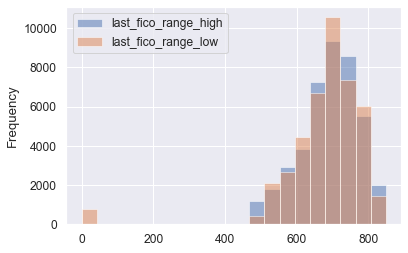

In [71]:
#analysis of the variables that potentially have the greatest impact on whether the loan will be repaid ast_fico_range high and last_fico_range_low

fico_columns = ['last_fico_range_high','last_fico_range_low']
print(loan_data.shape[0])
loan_data.dropna(subset=fico_columns,inplace=True)
print(loan_data.shape[0])
loan_data[fico_columns].plot.hist(alpha=0.5,bins=20);



In [72]:
print(loan_data['last_fico_range_high'].unique())
print(loan_data['last_fico_range_low'].unique())

[739. 499. 604. 684. 564. 654. 689. 504. 779. 669. 619. 799. 694. 644.
 794. 559. 534. 774. 734. 509. 579. 719. 599. 674. 574. 754. 724. 709.
 614. 829. 704. 594. 784. 639. 659. 789. 679. 699. 804. 624. 749. 524.
 664. 629. 609. 649. 714. 819. 549. 544. 769. 634. 744. 839. 814. 569.
 554. 764. 729. 759. 539. 809. 589. 529. 584. 824. 519. 514. 834. 844.
 850.   0.]
[735.   0. 600. 680. 560. 650. 685. 500. 775. 665. 615. 795. 690. 640.
 790. 555. 530. 770. 730. 505. 575. 715. 595. 670. 570. 750. 720. 705.
 610. 825. 700. 590. 780. 635. 655. 785. 675. 695. 800. 620. 745. 520.
 660. 625. 605. 645. 710. 815. 545. 540. 765. 630. 740. 835. 810. 565.
 550. 760. 725. 755. 535. 805. 585. 525. 580. 820. 515. 510. 830. 840.
 845.]


The last_fico_range_high and last_fico_range_low values overlap, which means that the differences between them are not high. For security reasons, a column will be created showing the average of these values - fico_average, and last_fico_range_high and last_fico_range_low will be removed

In [73]:
#added column - FICO range average and remove last_fico_range_high and last_fico_range_low

In [74]:
loan_data_dummy['fico_average'] = (loan_data_dummy['last_fico_range_high'] + loan_data_dummy['last_fico_range_low']) / 2

In [75]:
drop_cols5 = ['last_fico_range_high','last_fico_range_low']
loan_data_dummy = loan_data_dummy.drop(drop_cols5,axis=1)

In [76]:
loan_data_dummy.head()

loan_amnt  term_in_months  grade  emp_length  annual_inc  loan_status  \
0     5000.0              36      2        10.0     24000.0            1   
1     2500.0              60      3         0.0     30000.0            0   
2     2400.0              36      3        10.0     12252.0            1   
3    10000.0              36      3        10.0     49200.0            1   
4     3000.0              60      2         1.0     80000.0            1   

     dti  delinq_2yrs  fico_range_low  fico_range_high  ...  purpose_medical  \
0  27.65          0.0           735.0            739.0  ...                0   
1   1.00          0.0           740.0            744.0  ...                0   
2   8.72          0.0           735.0            739.0  ...                0   
3  20.00          0.0           690.0            694.0  ...                0   
4  17.94          0.0           695.0            699.0  ...                0   

   purpose_moving  purpose_other  purpose_renewable_energy  \
0               0              0                         0   
1               0              0                         0   
2               0              0                         0   
3               0              1                         0   
4               0              1                         0   

   purpose_small_business  purpose_vacation  purpose_wedding  \
0                       0                 0                0   
1                       0                 0                0   
2                       1                 0                0   
3                       0                 0                0   
4                       0                 0                0   

   debt_settlement_flag_N  debt_settlement_flag_Y  fico_average  
0                       1                       0         737.0  
1                       1                       0         249.5  
2                       1                       0         737.0  
3                       1                       0         602.0  
4                       1                       0         682.0  

[5 rows x 41 columns]

C:\Users\Anusia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


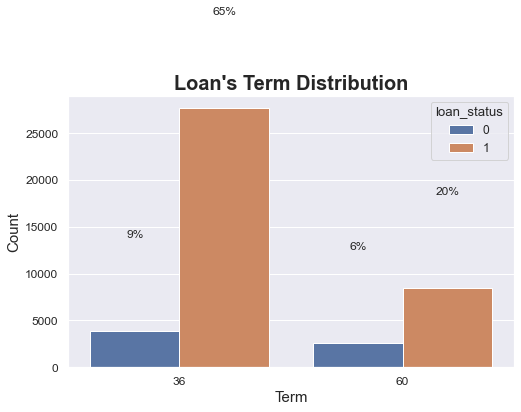

In [77]:
#review other data - columns - Loan's Term
plt.figure(figsize=(8, 5))
plot2 = sns.countplot(loan_data.term_in_months, hue = loan_data.loan_status)
plt.title("Loan's Term Distribution", fontsize = 20, weight='bold')
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Term", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

total = len(loan_data)
sizes = []
for p in plot2.patches:
    height = p.get_height()
    sizes.append(height)
    plot2.text(p.get_x() + p.get_width()/2.,
            height + 10000,
            '{:1.0f}%'.format(height/total*100),
            ha = "center", 
            fontsize = 12) 

The majority of borrowers want to pay off the loan in 36 months. Fewer people use the 60-month loan repayment period. It is worth noting that almost 1/4 of these loans are classified as unpaid.

C:\Users\Anusia\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([0.e+00, 1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05,
        8.e-05, 9.e-05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

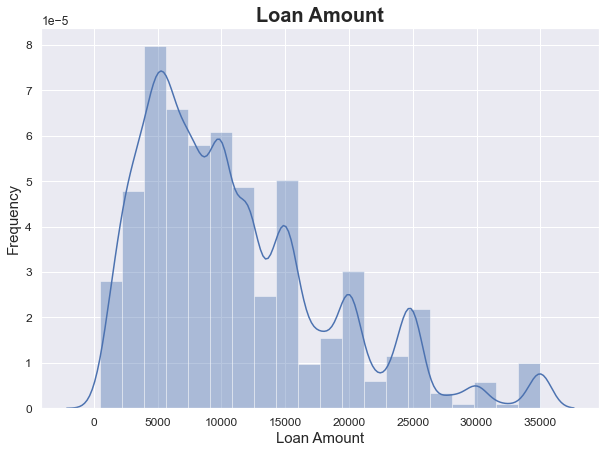

In [78]:
#review column Loan Amount
plt.figure(figsize = (10,7))
sns.distplot(loan_data.loan_amnt, bins=20)
plt.title('Loan Amount', fontsize = 20, weight='bold')
plt.xlabel('Loan Amount', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

Most borrowers take out loans ranging from 5,000 to 15,000. The smallest number of loans is over 30,000.

C:\Users\Anusia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

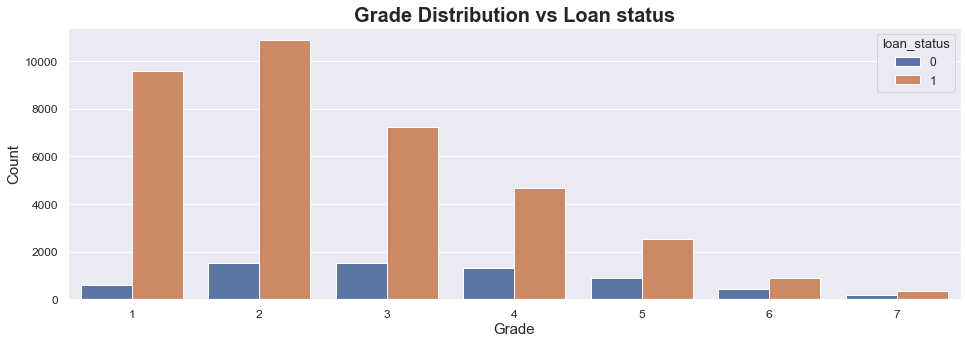

In [79]:
#review column Grade
plt.figure(figsize = (16,5))
plot3 = sns.countplot(loan_data.sort_values(by='grade').grade, hue = loan_data.loan_status)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Grade Distribution vs Loan status", fontsize = 20, weight='bold')
plt.xlabel("Grade", fontsize = 15)
plt.ylabel("Count", fontsize = 15)


The chart above shows that from grade 2-5 there are the most so-called bad credit, i.e. there is a risk that this loan status may not be repaid. On the other hand, grade 1 to 5 has by far the largest share of repaid loans.

C:\Users\Anusia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

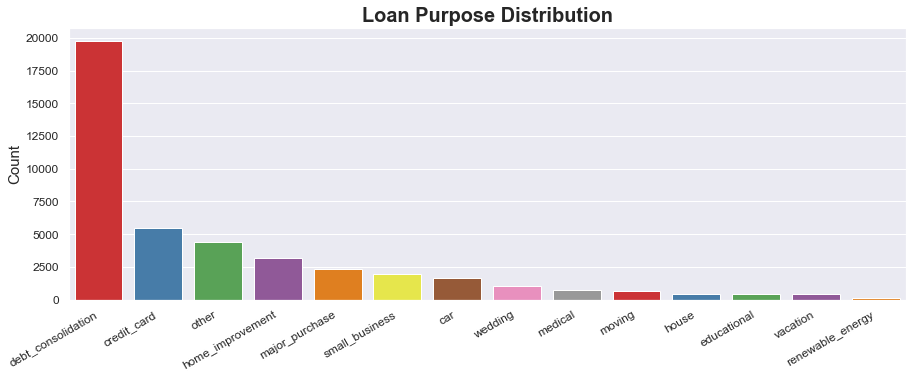

In [80]:
#review columnLoan Purpose
plt.figure(figsize = (15,5))
plot4 = sns.barplot(loan_data.purpose.value_counts().index, loan_data.purpose.value_counts(), palette = 'Set1')
plt.xticks(rotation = 30, fontsize = 12, horizontalalignment='right')
plt.yticks(fontsize = 12)
plt.title("Loan Purpose Distribution", fontsize = 20, weight='bold')
plt.ylabel("Count", fontsize = 15)

Borrowers most often take a loan on debt_consolidation. Then they are credit_card, other, home_improvement. The least amount of credit are vacation and renewable_energy

C:\Users\Anusia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

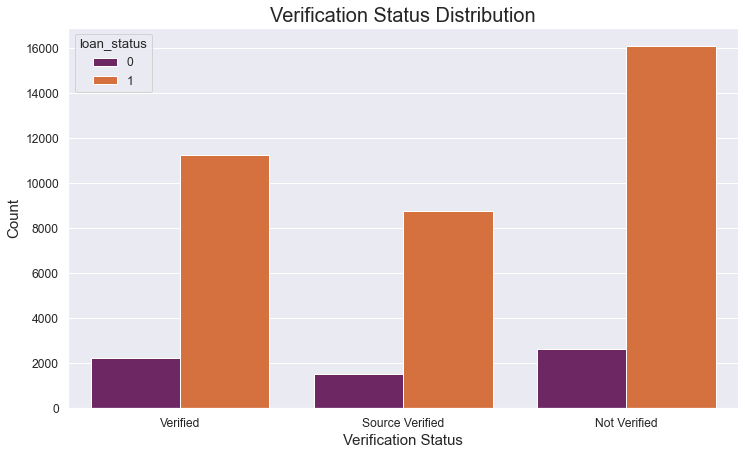

In [81]:
#review column Verification Status
plt.figure(figsize=(12, 7))
plot5 = sns.countplot(loan_data.verification_status, hue = loan_data.loan_status, palette = 'inferno')
plt.title("Verification Status Distribution", fontsize = 20)
plt.xlabel("Verification Status", fontsize = 15)
plt.ylabel("Count", fontsize = 15)

Based on the chart above, it can be concluded that not verified applications had the most bad loans. This means that the verification status can be a good factor in predicting the loan quality.

## 2.2. Outlier analysis

In [82]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42506 entries, 0 to 42514
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             42506 non-null  float64
 1   funded_amnt_inv       42506 non-null  float64
 2   term_in_months        42506 non-null  int64  
 3   installment           42506 non-null  float64
 4   grade                 42506 non-null  int64  
 5   emp_length            42506 non-null  float64
 6   home_ownership        42506 non-null  object 
 7   annual_inc            42506 non-null  float64
 8   verification_status   42506 non-null  object 
 9   loan_status           42506 non-null  int64  
 10  purpose               42506 non-null  object 
 11  dti                   42506 non-null  float64
 12  delinq_2yrs           42506 non-null  float64
 13  fico_range_low        42506 non-null  float64
 14  fico_range_high       42506 non-null  float64
 15  inq_last_6mths     

In [83]:
loan_data_dummy['annual_inc']


0         24000.0
1         30000.0
2         12252.0
3         49200.0
4         80000.0
           ...   
42509      4000.0
42511     50000.0
42512    150000.0
42513     20000.0
42514     30000.0
Name: annual_inc, Length: 42506, dtype: float64

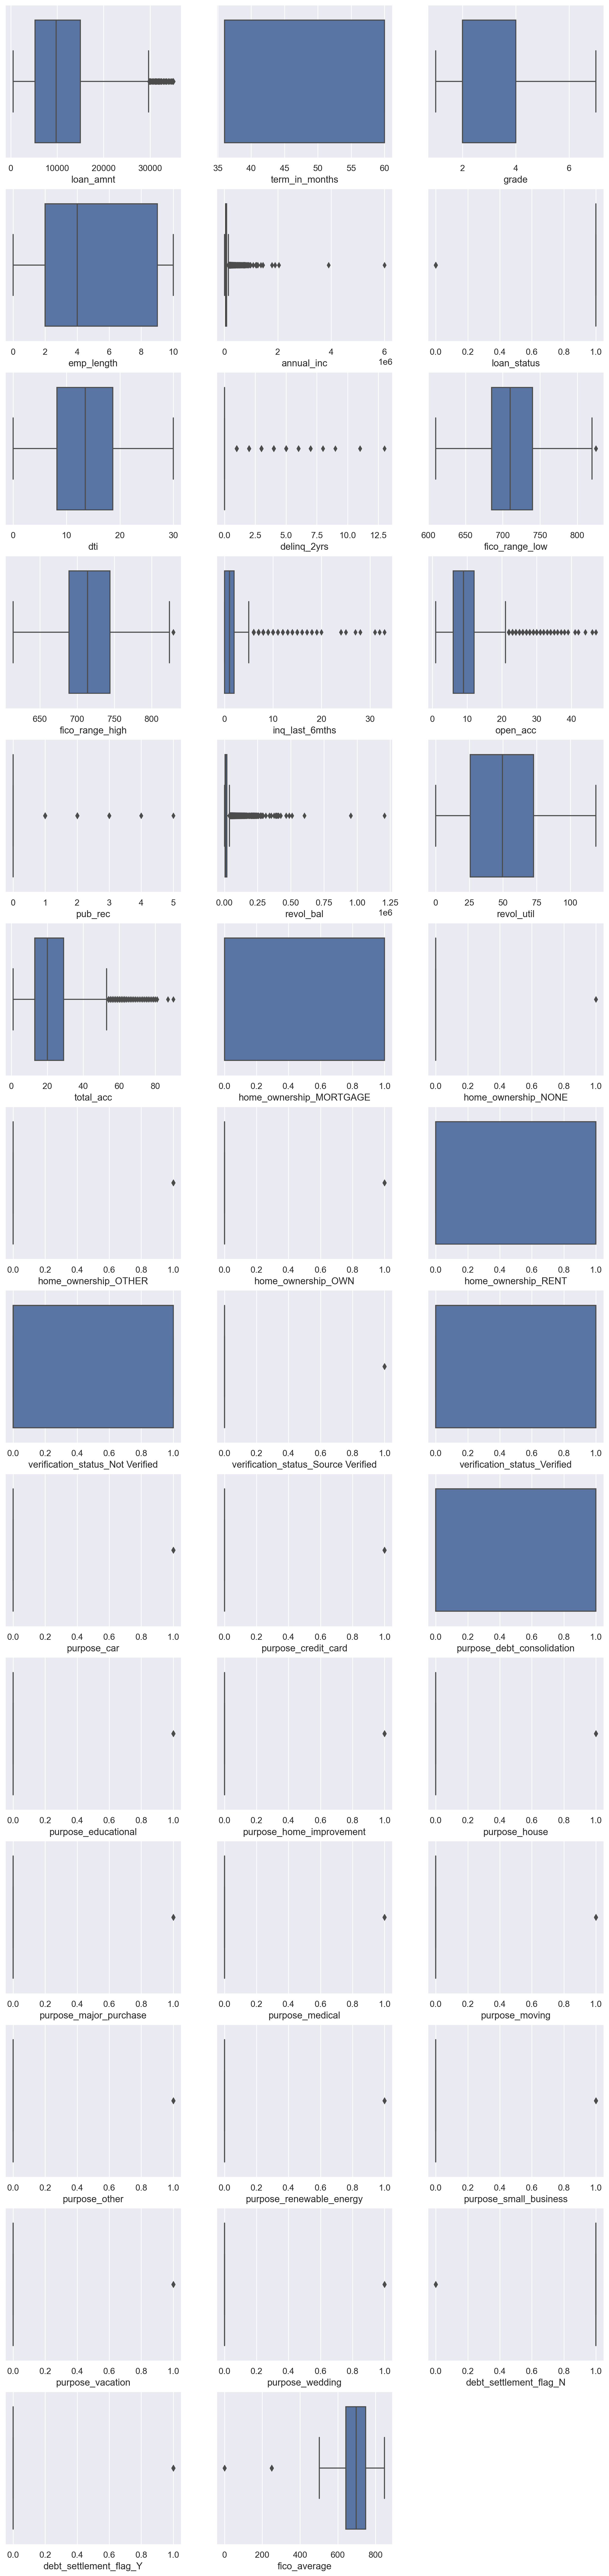

In [84]:
#boxplots

plt.figure(figsize=(15,70), dpi=200)
for i in range (0,len(loan_data_dummy.columns)):
    plt.subplot(15,3,i+1)
    sns.boxplot(x=loan_data_dummy.columns[i], data = loan_data_dummy)
plt.show()

Based on the analysis of outliers, the most outlier values will be replaced with the values closest to them in the columns: annual_inc, revo_bal and fico_average

In [85]:
#replacing outliers from the annual_inc column
upper_lim = loan_data_dummy['annual_inc'].quantile(.99)
loan_data_dummy.loc[(loan_data_dummy['annual_inc'] > upper_lim),'annual_inc'] = upper_lim

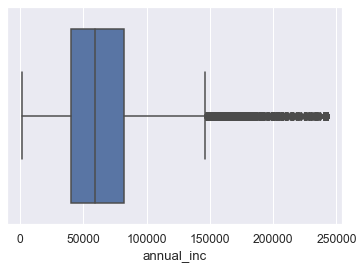

In [86]:
sns.boxplot(x=loan_data_dummy['annual_inc'], data = loan_data_dummy)
plt.show()

In [87]:
#replacing outliers from the revol_bal
upper_lim2 = loan_data_dummy['revol_bal'].quantile(.98)
upper_lim2

72331.50000000003

In [88]:
loan_data_dummy.loc[(loan_data_dummy['revol_bal'] > upper_lim2),'revol_bal'] = upper_lim2

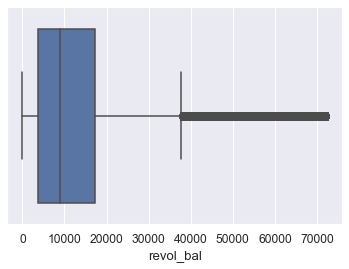

In [89]:
sns.boxplot(x=loan_data_dummy['revol_bal'], data = loan_data_dummy)
plt.show()

In [90]:
#replacing outliers from column fico_average
lower_lim = loan_data_dummy['fico_average'].quantile(.02)
lower_lim


502.0

In [91]:
loan_data_dummy['fico_average'][loan_data_dummy['fico_average']<lower_lim].count()

794

In [92]:
loan_data_dummy.loc[(loan_data_dummy['fico_average'] < lower_lim),'fico_average'] = lower_lim

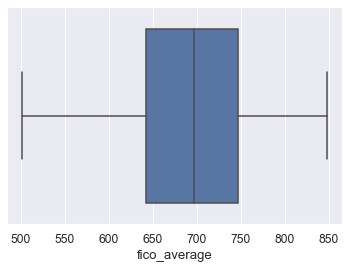

In [93]:
sns.boxplot(x=loan_data_dummy['fico_average'], data = loan_data_dummy)
plt.show()

In [94]:
#remove outliers for delinq_2yrs oraz inq_last_6mths and pub_rec o open_acc
upper_lim3 = loan_data_dummy['delinq_2yrs'].quantile(.99)
upper_lim3

2.0

In [95]:
loan_data_dummy['delinq_2yrs'][loan_data_dummy['delinq_2yrs']>upper_lim3].count()

369

In [96]:
loan_data_dummy = loan_data_dummy.drop(loan_data_dummy[(loan_data_dummy['delinq_2yrs']>upper_lim3)].index).reset_index(drop=True)

In [97]:
upper_lim4 = loan_data_dummy['inq_last_6mths'].quantile(.98)
upper_lim4

5.0

In [98]:
loan_data_dummy['inq_last_6mths'][loan_data_dummy['inq_last_6mths']>upper_lim4].count()

772

In [99]:
loan_data_dummy = loan_data_dummy.drop(loan_data_dummy[(loan_data_dummy['inq_last_6mths']>upper_lim4)].index).reset_index(drop=True)

In [100]:
upper_lim5 = loan_data_dummy['pub_rec'].quantile(.99)
upper_lim5

1.0

In [101]:
loan_data_dummy['pub_rec'][loan_data_dummy['pub_rec']>upper_lim5].count()

71

In [102]:
loan_data_dummy = loan_data_dummy.drop(loan_data_dummy[(loan_data_dummy['pub_rec']>upper_lim5)].index).reset_index(drop=True)

In [103]:
upper_lim6 = loan_data_dummy['open_acc'].quantile(.99)
upper_lim6

22.06999999999971

In [104]:
loan_data_dummy['open_acc'][loan_data_dummy['open_acc']>upper_lim6].count()

413

In [105]:
loan_data_dummy = loan_data_dummy.drop(loan_data_dummy[(loan_data_dummy['open_acc']>upper_lim6)].index).reset_index(drop=True)

## 2.3. Answering to the questions

In [106]:
loan_data_dummy.columns.tolist()

['loan_amnt',
 'term_in_months',
 'grade',
 'emp_length',
 'annual_inc',
 'loan_status',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Not Verified',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'debt_settlement_flag_N',
 'debt_settlement_flag_Y',
 'fico_average']

# 1. How does the FICO score relate to the likelihood of the borrower repaying the loan?

<AxesSubplot:xlabel='loan_status', ylabel='fico_average'>

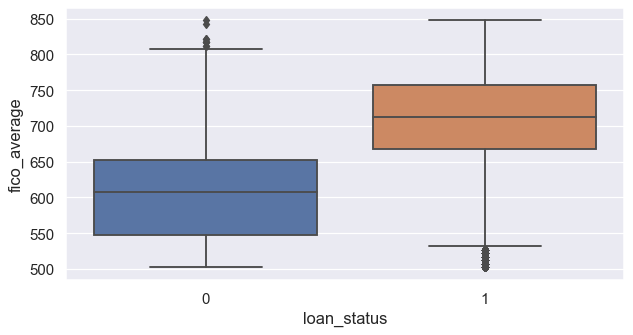

In [107]:
plt.figure(figsize=(8,4),dpi=90)
sns.boxplot(x='loan_status', y='fico_average', data=loan_data_dummy)

Answer: An increase in the average FICO value has a positive effect on the probability of the borrower's repayment of the loan

# 2. How is the credit age related to the probability of default and is this risk independent or related to the FICO score?

<AxesSubplot:xlabel='term_in_months', ylabel='fico_average'>

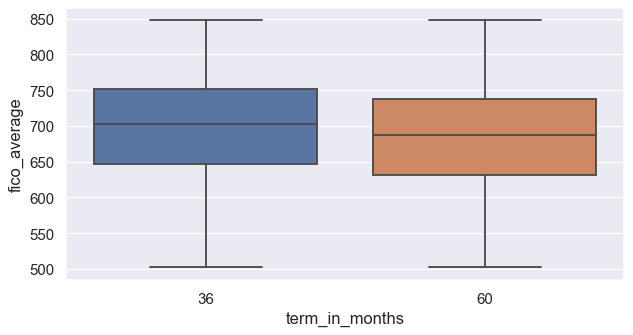

In [108]:
plt.figure(figsize=(8,4),dpi=90)
sns.boxplot(x='term_in_months', y='fico_average', data=loan_data_dummy)

C:\Users\Anusia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Loan Status by Loan Amount')

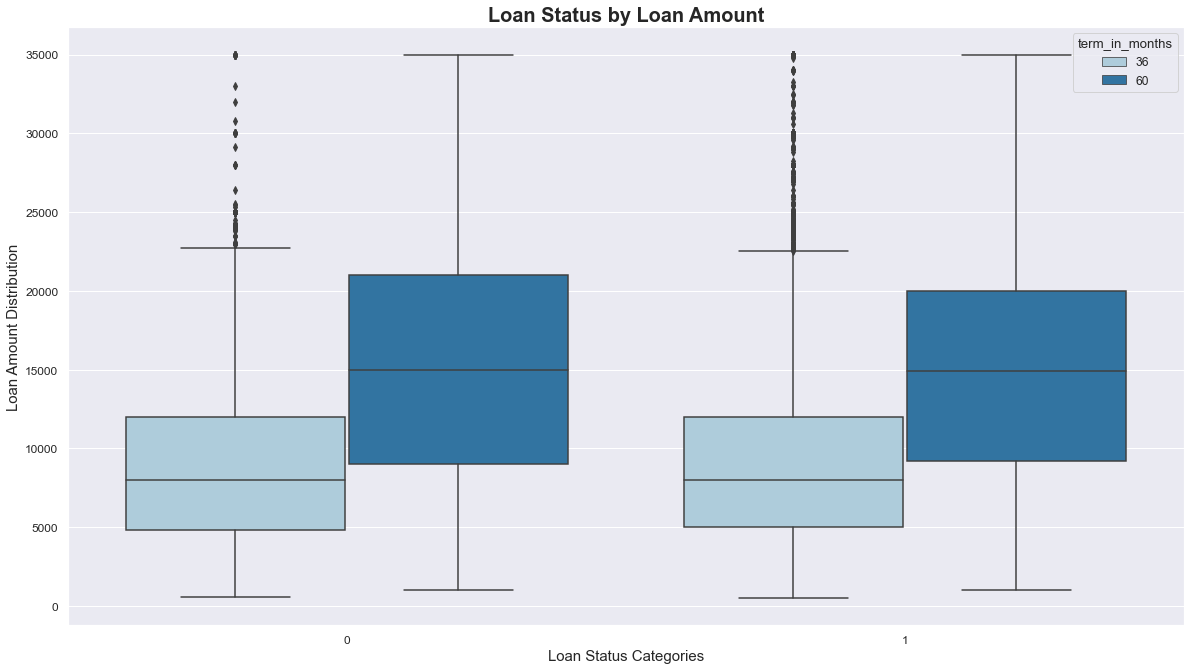

In [109]:
plt.figure(figsize = (20,11))
sns.boxplot(loan_data_dummy.loan_status, loan_data_dummy.loan_amnt, hue = loan_data_dummy.term_in_months, palette = 'Paired')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Loan Status Categories", fontsize = 15)
plt.ylabel("Loan Amount Distribution", fontsize = 15)
plt.title("Loan Status by Loan Amount", fontsize = 20, weight='bold')

Answer: It is worth noting that both a repaid and an unpaid loan have relatively the same loan amount (for both loan ages). With the exception of a 60-month loan repaid, the average amount is slightly higher compared to the average loan amount. This means that the loan amount alone may not necessarily predict the loan category.

# 3. How is my home mortgage status related to my likelihood of default?

<AxesSubplot:xlabel='loan_status', ylabel='purpose_house'>

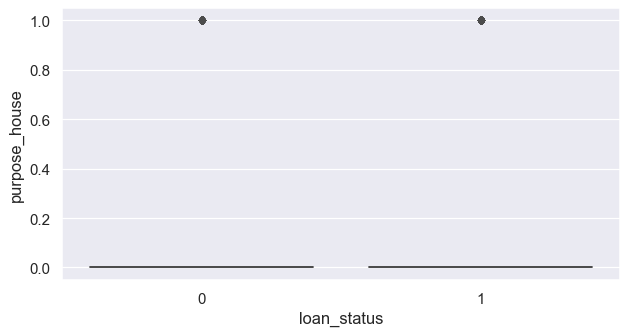

In [110]:
plt.figure(figsize=(8,4),dpi=90)
sns.boxplot(x='loan_status', y='purpose_house', data=loan_data_dummy)

Answer: The status of your home mortgage does not affect your probability of default

# 4. How is annual income related to the probability of default?

<AxesSubplot:xlabel='loan_status', ylabel='annual_inc'>

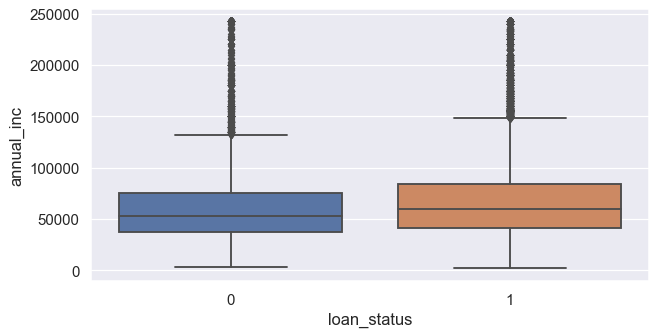

In [111]:
plt.figure(figsize=(8,4),dpi=90)
sns.boxplot(x='loan_status', y='annual_inc', data=loan_data_dummy)

Answer: Increasing annual income has little effect on the likelihood of the borrower's repayment of the loan

# 5. How is your employment history related to the probability of default?


<AxesSubplot:xlabel='loan_status', ylabel='emp_length'>

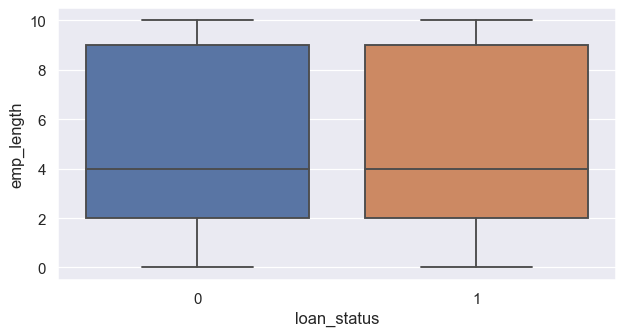

In [112]:
plt.figure(figsize=(8,4),dpi=90)
sns.boxplot(x='loan_status', y='emp_length', data=loan_data_dummy)

Answer: Employment history is not related to default.

# 6. How is the size of the requested loan related to the probability of default?


<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

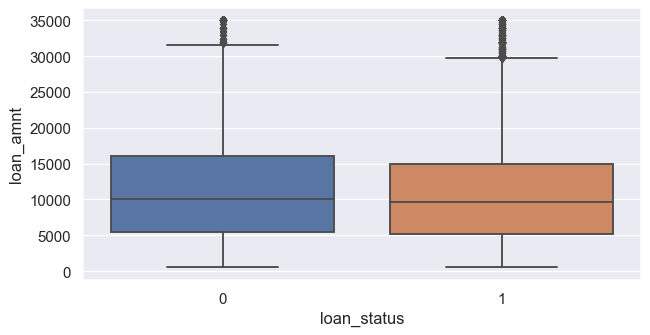

In [113]:
plt.figure(figsize=(8,4),dpi=90)
sns.boxplot(x='loan_status', y='loan_amnt', data=loan_data_dummy)

Answer: The increase in the requested loan size is slightly related to the default.

# 3. Feature engineering

Some of the operations related to Feature Engineering for the purposes of data analysis were carried out earlier, e.g. one-hot encoding, imputation, handling outliers

In [114]:
#adding a categorical column based on FICO average

loan_data_dummy['Rating'] = pd.cut(loan_data_dummy['fico_average'], bins = [0,580,670,740,800,loan_data_dummy['fico_average'].max()], labels=[0, 1, 2, 3, 4])

0 - poor
1 - Fair
2 - Good
3 - Very good
4 - Exeptional

In [115]:
loan_data_dummy[['Rating','fico_average']]

Rating  fico_average
0          2         737.0
1          0         502.0
2          2         737.0
3          1         602.0
4          2         682.0
...      ...           ...
40876      2         702.0
40877      0         502.0
40878      4         807.0
40879      3         767.0
40880      0         547.0

[40881 rows x 2 columns]

# 4. Modeling

## 4. 1. The use of three clustering algorithms - KMeans, Hierarchical and DBScan + selection of a specific number of clusters

In [116]:
X = loan_data_dummy[['loan_amnt', 'term_in_months', 'grade', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low','fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal','revol_util', 'total_acc','fico_average', 'Rating']]  
y = loan_data_dummy['loan_status']

In [117]:
#data standarization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [118]:
X_scaled_loan_data = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled_loan_data = pd.concat([X_scaled_loan_data, loan_data_dummy[['home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'debt_settlement_flag_N',
       'debt_settlement_flag_Y', 'loan_status']]], axis = 1)
X_scaled_loan_data.head()

loan_amnt  term_in_months     grade  emp_length  annual_inc       dti  \
0  -0.825138       -0.592897 -0.435997    1.442463   -1.091968  2.129600   
1  -1.162344        1.686632  0.276165   -1.331324   -0.939640 -1.838018   
2  -1.175832       -0.592897  0.276165    1.442463   -1.390226 -0.688675   
3  -0.150727       -0.592897  0.276165    1.442463   -0.452190  0.990677   
4  -1.094903        1.686632 -0.435997   -1.053946    0.329761  0.683987   

   delinq_2yrs  fico_range_low  fico_range_high  inq_last_6mths  ...  \
0    -0.321232        0.585719         0.585719        0.041448  ...   
1    -0.321232        0.724304         0.724304        3.466279  ...   
2    -0.321232        0.585719         0.585719        0.897656  ...   
3    -0.321232       -0.661549        -0.661549        0.041448  ...   
4    -0.321232       -0.522964        -0.522964       -0.814760  ...   

   purpose_medical  purpose_moving  purpose_other  purpose_renewable_energy  \
0                0               0              0                         0   
1                0               0              0                         0   
2                0               0              0                         0   
3                0               0              1                         0   
4                0               0              1                         0   

   purpose_small_business  purpose_vacation  purpose_wedding  \
0                       0                 0                0   
1                       0                 0                0   
2                       1                 0                0   
3                       0                 0                0   
4                       0                 0                0   

   debt_settlement_flag_N  debt_settlement_flag_Y  loan_status  
0                       1                       0            1  
1                       1                       0            0  
2                       1                       0            1  
3                       1                       0            1  
4                       1                       0            1  

[5 rows x 42 columns]

In [119]:
#remove n/a
X_scaled_loan_data = X_scaled_loan_data.dropna()

In [190]:
# KMeans
kmeans_rs = 42
kmeans = KMeans(n_clusters=5, max_iter=1000, random_state = kmeans_rs )
kmeans.fit(X_scaled_loan_data)

KMeans(max_iter=1000, n_clusters=5, random_state=42)

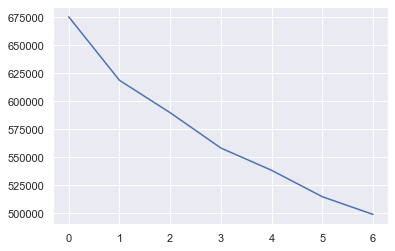

In [191]:
ssd = []
ssd = [] # Sum of squared distances
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000, random_state = kmeans_rs)
    kmeans.fit(X_scaled_loan_data)
    
    ssd.append(kmeans.inertia_) 
    
plt.plot(ssd)

In [192]:
range_n_clusters = [2, 3, 4, 5, 6]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000, random_state = kmeans_rs)
    kmeans.fit(X_scaled_loan_data)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_scaled_loan_data, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.12457457041693838
For n_clusters=3, the silhouette score is 0.11864544070908559
For n_clusters=4, the silhouette score is 0.11997465535899636
For n_clusters=5, the silhouette score is 0.11618980521729316
For n_clusters=6, the silhouette score is 0.0913672332519808


For KMeans, the best number of clusters will be 2.

In [193]:
#assignment of the calculated number of clusters
kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=kmeans_rs)
kmeans.fit(X_scaled_loan_data)

KMeans(max_iter=1000, n_clusters=2, random_state=42)

In [194]:
cluster_loan_data = X_scaled_loan_data.copy(deep=True)

In [195]:
cluster_loan_data['K-Means_Cluster_ID'] = kmeans.labels_

In [196]:
cluster_loan_data['K-Means_Cluster_ID'].value_counts()

1    23243
0    17638
Name: K-Means_Cluster_ID, dtype: int64

The data in the clusters is balanced.

array([[<AxesSubplot:title={'center':'Rating'}, xlabel='[K-Means_Cluster_ID]'>,
        <AxesSubplot:title={'center':'annual_inc'}, xlabel='[K-Means_Cluster_ID]'>,
        <AxesSubplot:title={'center':'debt_settlement_flag_N'}, xlabel='[K-Means_Cluster_ID]'>],
       [<AxesSubplot:title={'center':'debt_settlement_flag_Y'}, xlabel='[K-Means_Cluster_ID]'>,
        <AxesSubplot:title={'center':'delinq_2yrs'}, xlabel='[K-Means_Cluster_ID]'>,
        <AxesSubplot:title={'center':'dti'}, xlabel='[K-Means_Cluster_ID]'>],
       [<AxesSubplot:title={'center':'emp_length'}, xlabel='[K-Means_Cluster_ID]'>,
        <AxesSubplot:title={'center':'fico_average'}, xlabel='[K-Means_Cluster_ID]'>,
        <AxesSubplot:title={'center':'fico_range_high'}, xlabel='[K-Means_Cluster_ID]'>],
       [<AxesSubplot:title={'center':'fico_range_low'}, xlabel='[K-Means_Cluster_ID]'>,
        <AxesSubplot:title={'center':'grade'}, xlabel='[K-Means_Cluster_ID]'>,
        <AxesSubplot:title={'center':'home_ownership_

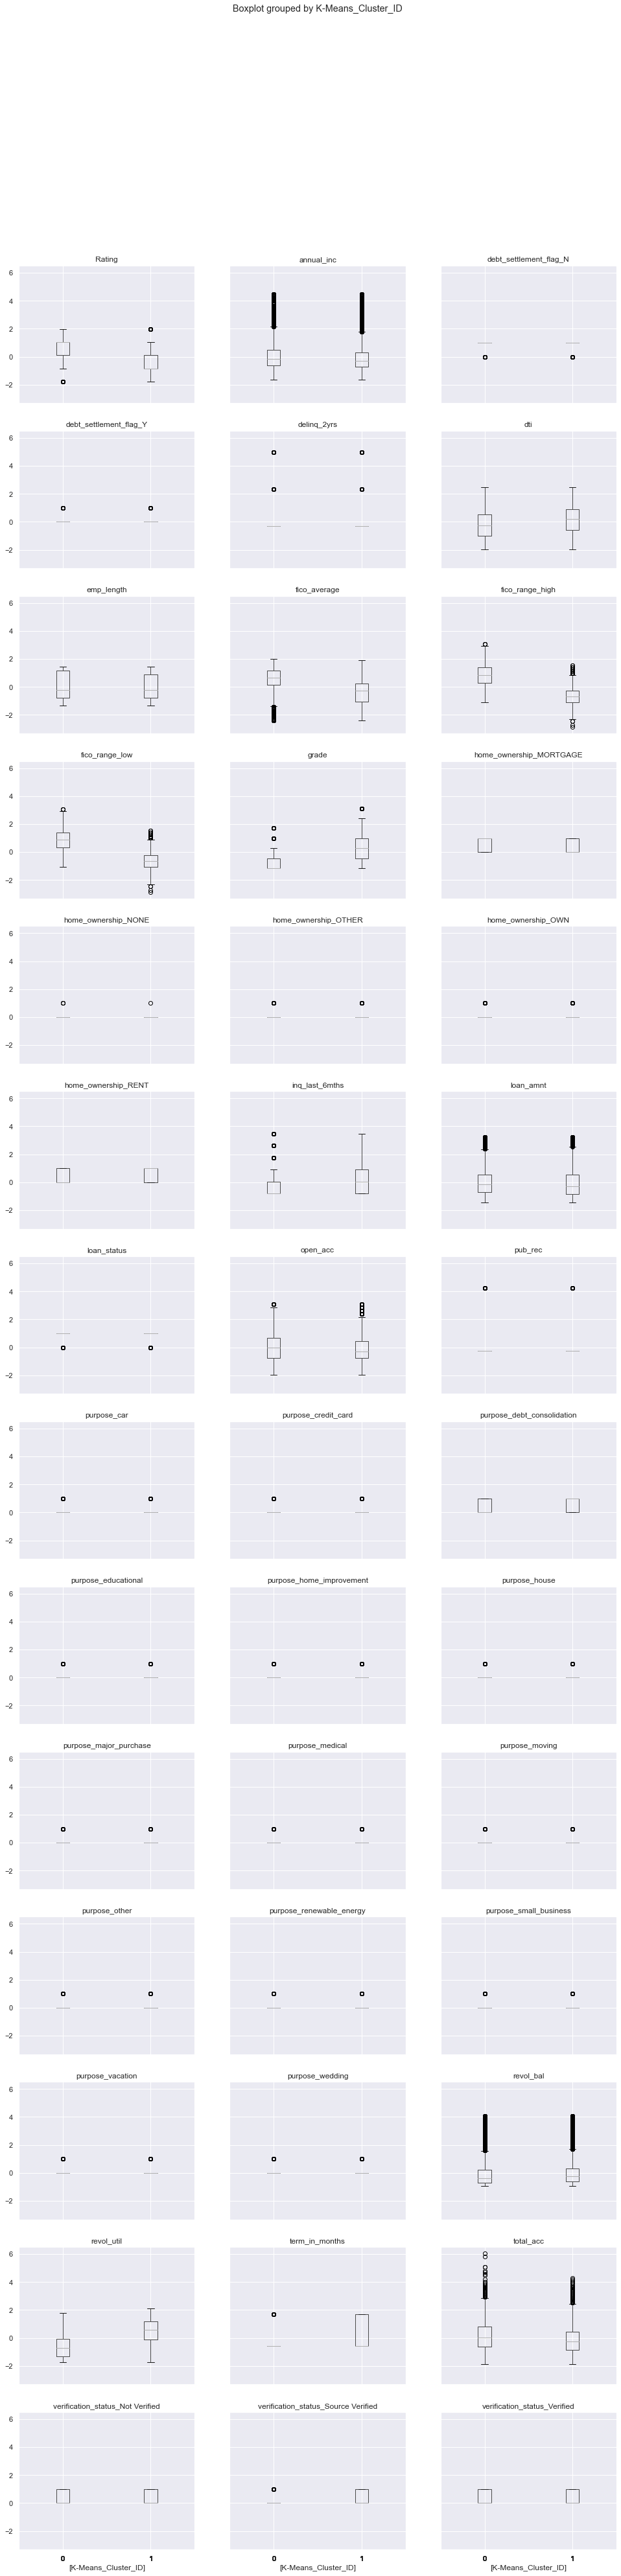

In [197]:
cluster_loan_data.boxplot(by = 'K-Means_Cluster_ID',  layout=(15,3), figsize=(16, 70))

CONCLUSIONS: Profitability in clusters is no different. The data is not balanced.
Two groups of borrowers can be distinguished, characterized by:
1) low rating, lower annual income, lower FICO, low grade, higher number of loan inquiries in the last 6 months, slightly lower loan amount requested, fewer open lines of credit, high revol_util, Source Verified status and terms in months 36.
2) high rating, higher annual income, lower FICO, high grade, lower number of loan inquiries in the last 6 months, slightly higher loan amount requested, more open lines of credit, low revol_util, no Source Verified status and terms in months 60.

In [128]:
cluster_loan_data = X_scaled_loan_data.copy(deep=True)

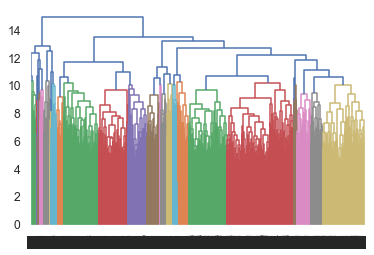

In [129]:
#Hierarchical clustering
cl_mergings = linkage(cluster_loan_data, method="complete", metric='euclidean')
dendrogram(cl_mergings)
plt.show()

In [130]:
#selection of the number of clusters - for comparability with the previous model, 4 clusters were also selected, although according to the method there should be more
cl_cluster_labels = cut_tree(cl_mergings, n_clusters=4).reshape(-1, )
cl_cluster_labels

array([0, 0, 0, ..., 2, 0, 0])

In [131]:
#adding a column with clusters for a Hierarchical cluster
cluster_loan_data["Hierarchical_Cluster_labels"] = cl_cluster_labels

In [132]:
cluster_loan_data.head()

loan_amnt  term_in_months     grade  emp_length  annual_inc       dti  \
0  -0.825138       -0.592897 -0.435997    1.442463   -1.091968  2.129600   
1  -1.162344        1.686632  0.276165   -1.331324   -0.939640 -1.838018   
2  -1.175832       -0.592897  0.276165    1.442463   -1.390226 -0.688675   
3  -0.150727       -0.592897  0.276165    1.442463   -0.452190  0.990677   
4  -1.094903        1.686632 -0.435997   -1.053946    0.329761  0.683987   

   delinq_2yrs  fico_range_low  fico_range_high  inq_last_6mths  ...  \
0    -0.321232        0.585719         0.585719        0.041448  ...   
1    -0.321232        0.724304         0.724304        3.466279  ...   
2    -0.321232        0.585719         0.585719        0.897656  ...   
3    -0.321232       -0.661549        -0.661549        0.041448  ...   
4    -0.321232       -0.522964        -0.522964       -0.814760  ...   

   purpose_moving  purpose_other  purpose_renewable_energy  \
0               0              0                         0   
1               0              0                         0   
2               0              0                         0   
3               0              1                         0   
4               0              1                         0   

   purpose_small_business  purpose_vacation  purpose_wedding  \
0                       0                 0                0   
1                       0                 0                0   
2                       1                 0                0   
3                       0                 0                0   
4                       0                 0                0   

   debt_settlement_flag_N  debt_settlement_flag_Y  loan_status  \
0                       1                       0            1   
1                       1                       0            0   
2                       1                       0            1   
3                       1                       0            1   
4                       1                       0            1   

   Hierarchical_Cluster_labels  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  

[5 rows x 43 columns]

array([[<AxesSubplot:title={'center':'Rating'}, xlabel='[Hierarchical_Cluster_labels]'>,
        <AxesSubplot:title={'center':'annual_inc'}, xlabel='[Hierarchical_Cluster_labels]'>,
        <AxesSubplot:title={'center':'debt_settlement_flag_N'}, xlabel='[Hierarchical_Cluster_labels]'>],
       [<AxesSubplot:title={'center':'debt_settlement_flag_Y'}, xlabel='[Hierarchical_Cluster_labels]'>,
        <AxesSubplot:title={'center':'delinq_2yrs'}, xlabel='[Hierarchical_Cluster_labels]'>,
        <AxesSubplot:title={'center':'dti'}, xlabel='[Hierarchical_Cluster_labels]'>],
       [<AxesSubplot:title={'center':'emp_length'}, xlabel='[Hierarchical_Cluster_labels]'>,
        <AxesSubplot:title={'center':'fico_average'}, xlabel='[Hierarchical_Cluster_labels]'>,
        <AxesSubplot:title={'center':'fico_range_high'}, xlabel='[Hierarchical_Cluster_labels]'>],
       [<AxesSubplot:title={'center':'fico_range_low'}, xlabel='[Hierarchical_Cluster_labels]'>,
        <AxesSubplot:title={'center':'grad

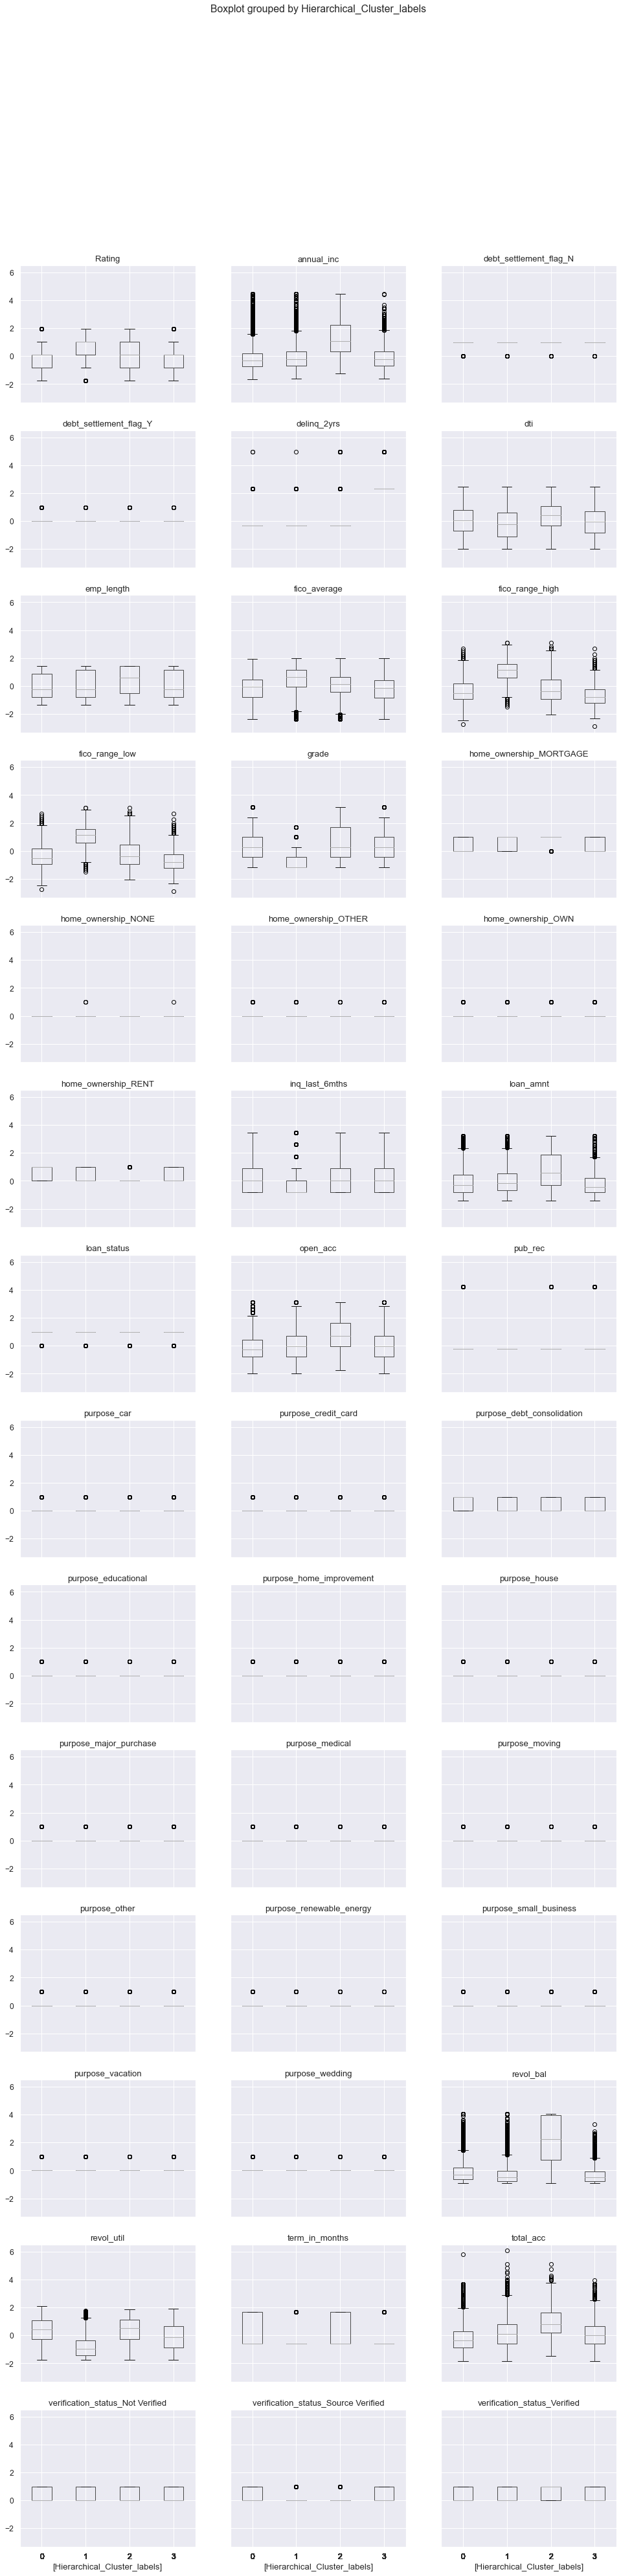

In [133]:

cluster_loan_data.boxplot(by = 'Hierarchical_Cluster_labels',  layout=(15,3), figsize=(16, 70))

In [134]:
cluster_loan_data = X_scaled_loan_data.copy(deep=True)

In [198]:
#DBScan
dbscan=DBSCAN()
dbscan.fit(cluster_loan_data)

DBSCAN()

In [199]:
dbscan_opt=DBSCAN(eps=30,min_samples=6)
dbscan_opt.fit(cluster_loan_data)

DBSCAN(eps=30, min_samples=6)

In [200]:
cluster_loan_data['K-Means_Cluster_ID'] = kmeans.labels_

In [201]:
cluster_loan_data["Hierarchical_Cluster_labels"] = cl_cluster_labels

In [202]:
cluster_loan_data["DBScan_labels"] = dbscan_opt.labels_

<AxesSubplot:xlabel='fico_average', ylabel='loan_amnt'>

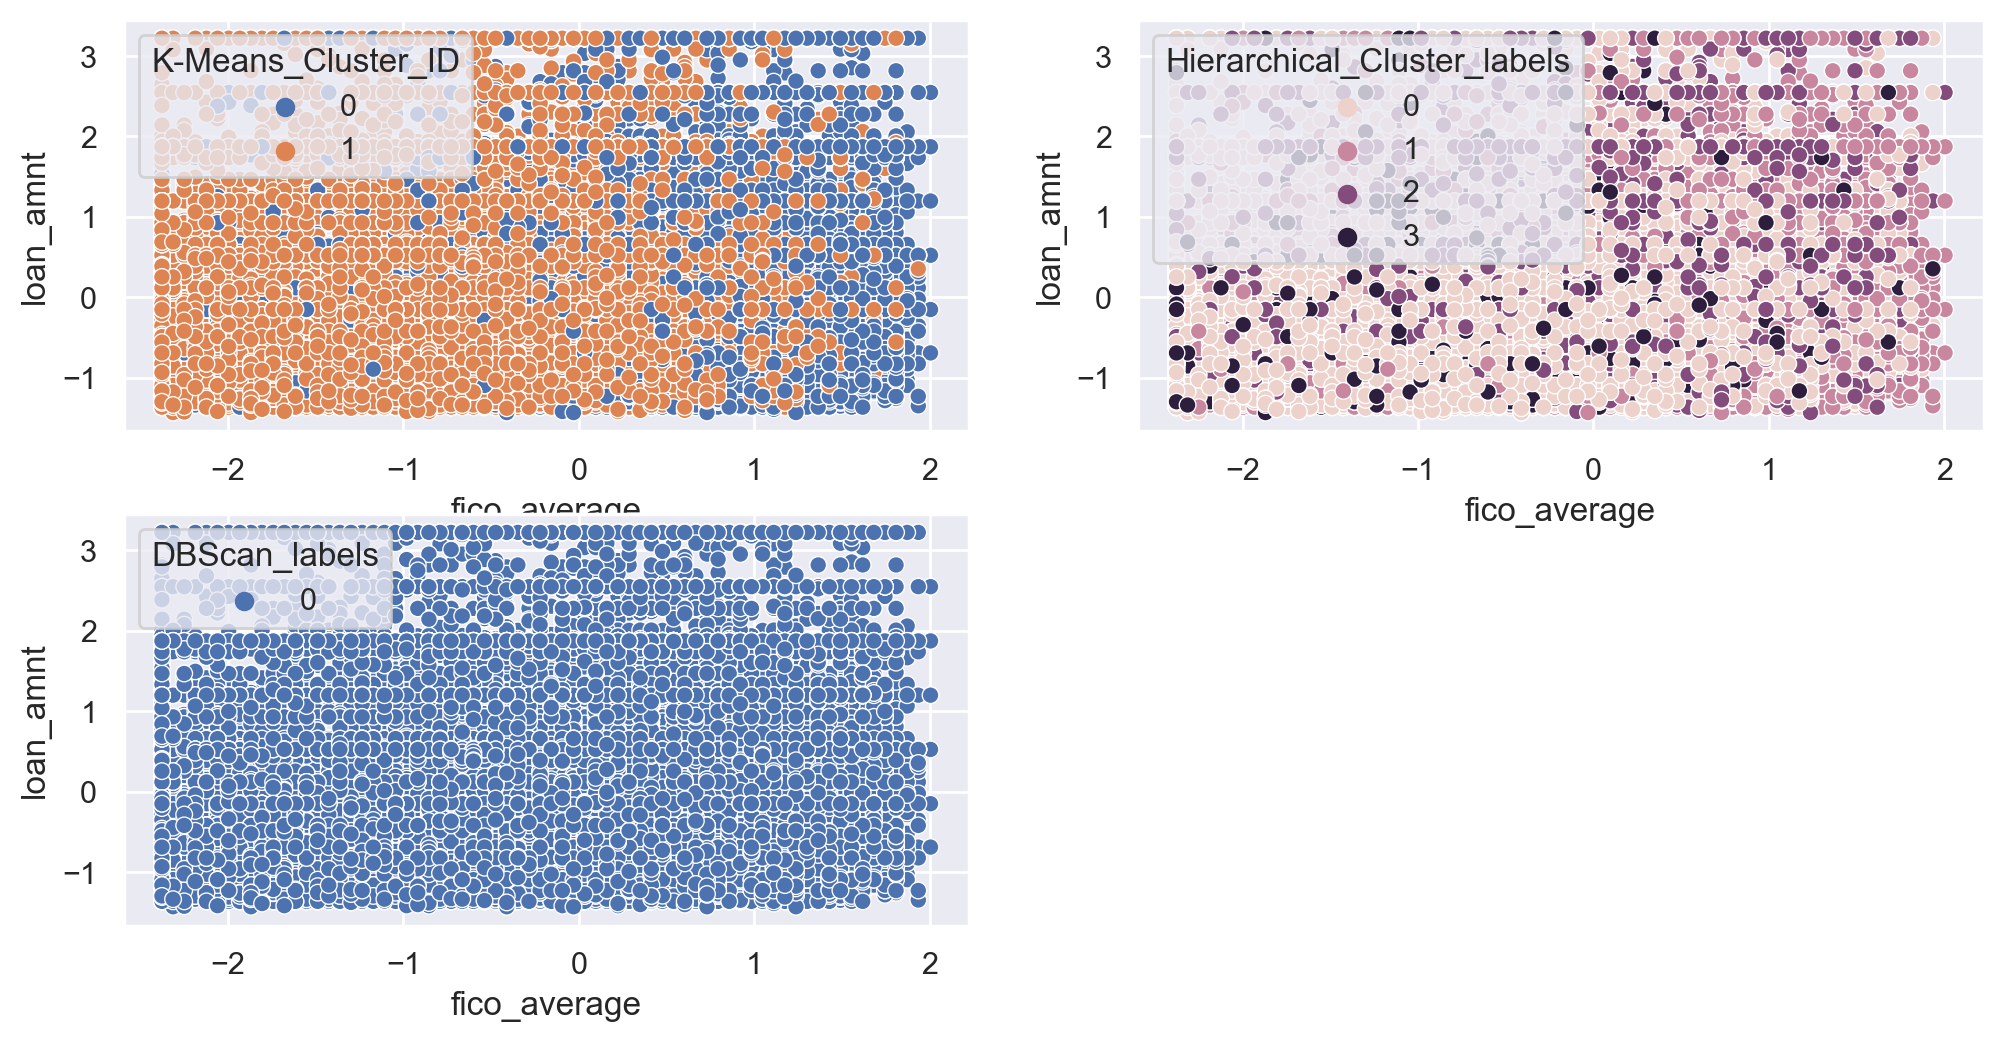

In [203]:
plt.figure(figsize=(12,6),dpi=200)

plt.subplot(2,2,1)
sns.scatterplot(x='fico_average',y='loan_amnt',data=cluster_loan_data,hue='K-Means_Cluster_ID')

plt.subplot(2,2,2)
sns.scatterplot(x='fico_average',y='loan_amnt',data=cluster_loan_data,hue='Hierarchical_Cluster_labels')

plt.subplot(2,2,3)
sns.scatterplot(x='fico_average',y='loan_amnt',data=cluster_loan_data,hue='DBScan_labels')

CONCLUSIONS: The best method of clustering is K-means because clusters have the least overlap

## 4.2. Train

In [272]:
##create train data
loan_data_dummy_scaled = X_scaled_loan_data.copy(deep=True)
target = loan_data_dummy_scaled.loan_status
loan_data_dummy_scaled.drop(columns=['loan_status'], inplace=True)
x_train, x_test, y_train, y_test = train_test_split(loan_data_dummy_scaled, target, test_size=0.4, random_state=1) 

In [273]:
#funcion to calcuate AUROC
def calc_auroc (xtest,ytest,model):
    lr_probs = model.predict_proba(xtest)
    lr_probs = lr_probs[:, 1]
    lr_auc = metrics.roc_auc_score(ytest, lr_probs)
    print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))
    return lr_auc

## 4.2.1. Logistic Regression

In [274]:
model_logreg = LogisticRegression()
model_logreg.fit(x_train, y_train)
logreg_prediction = model_logreg.predict(x_test)

C:\Users\Anusia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [275]:
#calculate AUROC
auroc_logreg = calc_auroc(x_test, y_test,model_logreg)

Logistic Regression: ROC AUC=0.872


## 4.2.2. Decistion Treee

In [276]:
model_dtree = DecisionTreeClassifier()
model_dtree.fit(x_train,y_train)
dt_prediction = model_dtree.predict(x_test)

In [277]:
#calculate AUROC
auroc_dt = calc_auroc(x_test, y_test,model_dtree)

Logistic Regression: ROC AUC=0.653


## 4.2.3. Random Forest Classifier

In [278]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(x_train, y_train)
rf_prediction = model_rf.predict(x_test)

In [290]:
#calculate AUROC
auroc_rfc = calc_auroc(x_test, y_test,model_rf)

Logistic Regression: ROC AUC=0.872


## 4.2.4. SVC

In [285]:
model_svc = SVC(probability=True)

In [286]:
model_svc.fit(x_train,y_train)
svc_prediction = model_svc.predict(x_test)

In [287]:
#calculate AUROC
auroc_svc = calc_auroc(x_test, y_test,model_svc)


Logistic Regression: ROC AUC=0.815


## 4.2.5. XGBoost

In [288]:
model_xgb=xgb.XGBClassifier()
model_xgb.fit(x_train, y_train)
xgb_prediction = model_xgb.predict(x_test)

[10:25:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Anusia\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Anusia\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [293]:
#calculate AUROC
auroc_xgb = calc_auroc(x_test, y_test,model_xgb)

Logistic Regression: ROC AUC=0.866


## 4.2.6. Accuracy summary on all models

In [294]:
auroc_data={'Model':['Logistic Regression',
                          ' Decision Tree',
                          'Random Forest Classifier',
                          'SVC',
                          'XGBoost Classifier'
                         ],
                                           
                 
                   'AUROC':[auroc_logreg,
                              auroc_dt,
                               auroc_rfc,
                               auroc_svc,
                               auroc_xgb
                               ]
                              
                    }
 
auroc_data = pd.DataFrame(auroc_data)
auroc_data

Model     AUROC
0       Logistic Regression  0.871944
1             Decision Tree  0.652885
2  Random Forest Classifier  0.872320
3                       SVC  0.815221
4        XGBoost Classifier  0.865531

Due to the fact that no PCA was carried out, the parameters of the models were not adjusted. The model with the highest AUROC score before PCA is applied is the Random Forest Classifier.

# 5. PCA

In [154]:
pca = PCA(random_state=42) #default values
pca.fit(loan_data_dummy_scaled)

PCA(random_state=42)

In [155]:
#how much the explainability of variance will change after adding another variable
pca.explained_variance_ratio_

array([1.97955130e-01, 1.52032350e-01, 7.79428533e-02, 7.54448972e-02,
       6.49538307e-02, 5.78631616e-02, 5.39683125e-02, 5.14449930e-02,
       4.52865280e-02, 3.57356704e-02, 2.91434375e-02, 2.15414911e-02,
       2.09299555e-02, 1.86768984e-02, 1.65271485e-02, 1.40337094e-02,
       1.33517840e-02, 1.24227948e-02, 9.62248273e-03, 5.72895253e-03,
       5.42966933e-03, 4.20743886e-03, 3.21704864e-03, 2.56727600e-03,
       2.37272151e-03, 2.06637488e-03, 1.37679107e-03, 1.01073351e-03,
       8.16035385e-04, 5.87025951e-04, 5.01877781e-04, 4.90035403e-04,
       3.93870245e-04, 2.11539539e-04, 1.38751286e-04, 6.42943022e-06,
       3.90397658e-32, 8.55531781e-34, 8.55531781e-34, 8.55531781e-34,
       2.54082494e-34])

In [156]:
#explainability of variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.19795513, 0.34998748, 0.42793033, 0.50337523, 0.56832906,
       0.62619222, 0.68016054, 0.73160553, 0.77689206, 0.81262773,
       0.84177116, 0.86331266, 0.88424261, 0.90291951, 0.91944666,
       0.93348037, 0.94683215, 0.95925495, 0.96887743, 0.97460638,
       0.98003605, 0.98424349, 0.98746054, 0.99002781, 0.99240054,
       0.99446691, 0.9958437 , 0.99685443, 0.99767047, 0.9982575 ,
       0.99875937, 0.99924941, 0.99964328, 0.99985482, 0.99999357,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [157]:
var_cumu[17]

0.9592549459303311

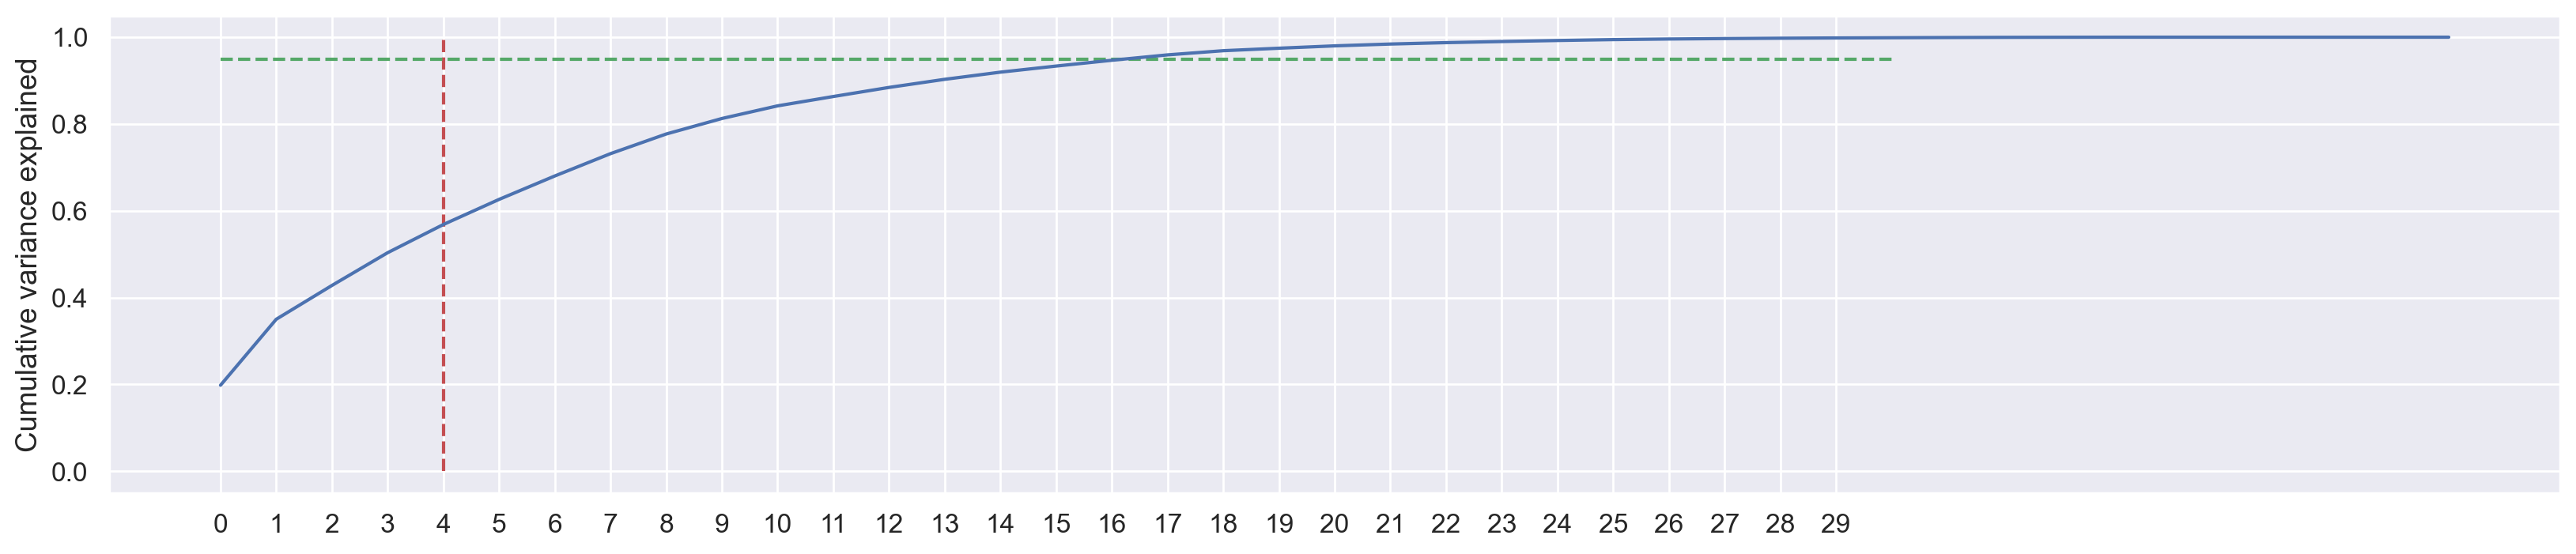

In [158]:
fig = plt.figure(figsize=[20,4],dpi=200)
plt.vlines(x=4, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.xticks(np.arange(0, 30, 1.0))
plt.show()

In [159]:
#the final PCA has 16 variables
pca_final = IncrementalPCA(n_components=16)
loan_data_dummy_pca = pca_final.fit_transform(X_scaled)


## 6. Training models after compressed data using the PCA method

In [160]:
loan_data_dummy_pca = pd.DataFrame(loan_data_dummy_pca)

In [161]:
loan_data_dummy_pca

0         1         2         3         4         5         6   \
0      0.218691 -1.006938 -0.945301  0.532530 -2.008988  0.484968  0.745679   
1     -0.755911 -3.159432  3.160557 -2.051787  1.083327  1.303389 -1.086514   
2      0.055731 -2.024684  0.076689  0.897699 -0.566863 -0.071923  0.900140   
3     -0.917347  0.366427 -0.323569 -1.792796 -0.044176  0.429158  0.273222   
4     -0.384391  1.504571 -1.035807 -0.463505 -0.555455  0.715550 -0.736530   
...         ...       ...       ...       ...       ...       ...       ...   
40876 -1.343153 -3.246470 -0.535830  1.243057  0.431724  0.817292 -0.550526   
40877 -4.471389 -0.503988 -0.082511 -0.975605  2.513331 -1.893862 -1.927747   
40878  4.595948  1.354781  0.174781  0.861471 -0.692841 -2.767989  0.568822   
40879 -0.464944 -1.743584 -1.284806  1.329043  0.686143  0.802011 -0.609523   
40880 -1.563323 -3.103198  0.942397 -0.689040 -1.021528 -1.271934 -0.229759   

             7         8         9         10        11        12        13  \
0     -0.627901  2.197666  1.442364  0.133255  0.309342  0.586509  0.041758   
1      2.575332  0.635388  0.814594 -1.574411 -0.640186 -0.212209  0.026833   
2      0.354312  2.445985  0.371070 -0.607394  1.298667 -0.725083  0.135551   
3     -0.758091  1.003587 -0.973395  1.024349 -0.132038  0.316149 -1.214673   
4     -0.385110 -1.348448 -0.855092 -1.971298 -0.273443  0.453874 -0.113171   
...         ...       ...       ...       ...       ...       ...       ...   
40876  0.274748  0.174267 -0.194896  1.009877 -1.709116  0.316668 -1.321445   
40877 -2.814330 -1.320418  0.818989 -0.065718  0.470324 -1.229130  1.050879   
40878  0.569300  0.279623  1.109004 -2.221160 -2.641404  0.000941 -0.809902   
40879  2.424042  1.053605  1.187357 -0.261448 -0.122380 -0.553774  0.197356   
40880  0.007791 -0.489772 -0.517215 -0.207528  0.143407 -0.480676  0.199689   

             14        15  
0      0.495496 -0.373211  
1     -0.014827  0.404421  
2      0.926716 -0.385947  
3     -0.205751  0.206453  
4     -0.651771  0.163970  
...         ...       ...  
40876 -0.424367 -0.036776  
40877  0.827785  0.431343  
40878  0.920287  0.313699  
40879 -0.083581  0.037237  
40880 -0.365299  0.027038  

[40881 rows x 16 columns]

In [295]:
##creating training data
target2 = X_scaled_loan_data.loan_status
x_train, x_test, y_train, y_test = train_test_split(loan_data_dummy_pca, target2, test_size=0.4, random_state=1) 

## 6.1. Logistic Regression

In [296]:
model_logreg = LogisticRegression()
model_logreg.fit(x_train, y_train)
logreg_prediction = model_logreg.predict(x_test)

In [297]:
#calculate AUROC
auroc_logreg2 = calc_auroc(x_test, y_test,model_logreg)

Logistic Regression: ROC AUC=0.864


## 6.2. Decistion Treee

In [310]:
model_dtree = DecisionTreeClassifier()
model_dtree.fit(x_train,y_train)
dt_prediction = model_dtree.predict(x_test)

In [311]:
#calculate AUROC
auroc_dt2 = calc_auroc(x_test, y_test,model_dtree)

Logistic Regression: ROC AUC=0.638


## 6.3. Random Forest Classifier

In [301]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(x_train, y_train)
rf_prediction = model_rf.predict(x_test)

In [302]:
#calculate AUROC
auroc_rfc2 = auroc_dt2 = calc_auroc(x_test, y_test,model_rf)

Logistic Regression: ROC AUC=0.854


## 6.4. SVC

In [303]:
model_svc = SVC(probability=True)

In [304]:
model_svc.fit(x_train,y_train)
svc_prediction = model_svc.predict(x_test)

In [305]:
#calculate AUROC
auroc_svc2 = calc_auroc(x_test, y_test,model_svc)

Logistic Regression: ROC AUC=0.803


## 6.5. XGBoost

In [306]:
model_xgb=xgb.XGBClassifier()
model_xgb.fit(x_train, y_train)
xgb_prediction = model_xgb.predict(x_test)

[10:33:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Anusia\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Anusia\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [307]:
#calculate AUROC
auroc_xgb2 = calc_auroc(x_test, y_test,model_xgb)

Logistic Regression: ROC AUC=0.853


## 6.6. Accuracy summary on all models before and after PCA

In [312]:
auroc_data={'Model':['Logistic Regression',
                          ' Decision Tree',
                          'Random Forest Classifier',
                          'SVC',
                          'XGBoost Classifier'
                         ],
                                           
                 
                   'AUROC':[auroc_logreg,
                              auroc_dt,
                               auroc_rfc,
                               auroc_svc,
                               auroc_xgb
                               ],
            'AUROC PCA':[auroc_logreg2,
                              auroc_dt2,
                               auroc_rfc2,
                               auroc_svc2,
                               auroc_xgb2
                               ],
                              
                    }
 
auroc_data = pd.DataFrame(auroc_data)
auroc_data

Model     AUROC  AUROC PCA
0       Logistic Regression  0.871944   0.863608
1             Decision Tree  0.652885   0.638145
2  Random Forest Classifier  0.872320   0.853545
3                       SVC  0.815221   0.802889
4        XGBoost Classifier  0.865531   0.853081

Due to the fact that no PCA was carried out, the parameters of the models were not adjusted. The model with the highest AUROC score before the application of PCA is the Random Forest Classifier and after the application of PCA it is the Logistic Regression.

## 7. Selecting one model and its careful analysis - Decision Tree

In [315]:
##creating training data - calculation without PCA as it gave better AUROCstworzenie danych treningowych - kalkulacja bez PCA, ponieważ dała lepsze AUROC
loan_data_dummy_scaled = X_scaled_loan_data.copy(deep=True)
target = loan_data_dummy_scaled.loan_status
loan_data_dummy_scaled.drop(columns=['loan_status'], inplace=True)
x_train, x_test, y_train, y_test = train_test_split(loan_data_dummy_scaled, target, test_size=0.4, random_state=1) 

## 7.1. Adjustment of parameters

In [347]:
model_dtree = DecisionTreeClassifier(random_state=0, min_samples_split=10,min_samples_leaf = 30, class_weight = {0:50,1:1},
                                    max_features = 9)
model_fit = model_dtree.fit(x_train,y_train)
dt_prediction = model_dtree.predict(x_test)


In [348]:
auroc_xgb3 = calc_auroc(x_test, y_test,model_dtree)


Logistic Regression: ROC AUC=0.844


After adjusting the parameters, the AUROC was increased to 0.844.

## 7.2. Calculation additional metrics

In [351]:
y_pred = model_dtree.predict(x_test)
print('Performance on training data using DT:',model_dtree.score(x_train,y_train))
print('Performance on testing data using DT:',model_dtree.score(x_test,y_test))
acc_DT=metrics.r2_score(y_test, y_pred)
print('Accuracy DT: ',acc_DT)
print('MSE: ',metrics.mean_squared_error(y_test, y_pred))

Performance on training data using DT: 0.5697570123939987
Performance on testing data using DT: 0.5535987280621293
Accuracy DT:  -2.526032352674301
MSE:  0.4464012719378707


There is not a big difference between test and training data.

In [352]:
#data analysis before PCA
def evaluate(prediction,y_test): 
    result = classification_report(y_test,prediction,output_dict=True)
    f1 = result['1']['f1-score']
    accuracy = result['accuracy']
    performance_data= {'f1-score':round(f1, 2),
                      'accuracy':round(accuracy, 2)}
    return performance_data

In [353]:
print(classification_report(y_test,y_pred))

dtree_pr= evaluate(y_pred,y_test)
dtree_pr

              precision    recall  f1-score   support

           0       0.24      0.95      0.39      2432
           1       0.98      0.48      0.65     13921

    accuracy                           0.55     16353
   macro avg       0.61      0.72      0.52     16353
weighted avg       0.87      0.55      0.61     16353



{'f1-score': 0.65, 'accuracy': 0.55}

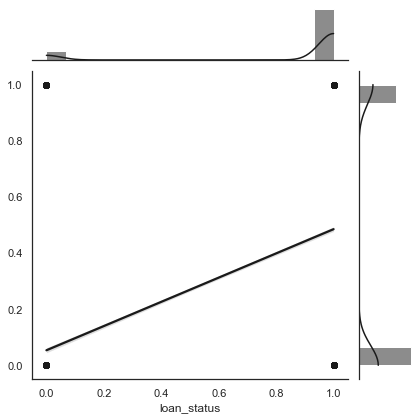

In [354]:
sns.set(style="darkgrid", color_codes=True)   
with sns.axes_style("white"):
    sns.jointplot(x=y_test, y=y_pred,kind="reg", color="k");

At the top, what distribution do the real predictions have, and the modeled predictions on y. Our goal is to make the speeds from the model similar to those that actually happened. Unfortunately, in this case the real and model prediction differs.

## 7.3. Cross-validate

In [355]:
crossval = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

In [356]:
num_folds = 10
kfold = KFold(n_splits=num_folds)
results1 = cross_val_score(model_dtree,loan_data_dummy_pca, target2, cv=kfold)
accuracy=np.mean(abs(results1))
print('Average accuracy: ',accuracy)
print('Standard Deviation: ',results1.std())

Average accuracy:  0.5891978095975121
Standard Deviation:  0.025336691223863304


After cross-validation, the accuracy increased to 58%. The model performs slightly better when cross-validation is used.

In [357]:
scores = cross_validate(model_dtree, loan_data_dummy_pca, target2, cv=10)

In [358]:
## source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

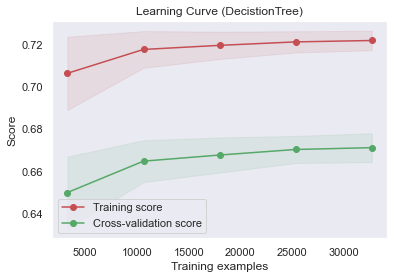

In [186]:
plot_learning_curve(model_dtree, 'Learning Curve (DecistionTree)', loan_data_dummy_pca, target2, cv=crossval, n_jobs=4)
plt.show()

The model seems to be slightly over-trained and not fit well.


## 7.4. Checking the significance of features

In [187]:
print('Feature importances: \n',pd.DataFrame(model_dtree.feature_importances_,columns=['Imp'],index=x_train.columns))

Feature importances: 
                                           Imp
loan_amnt                            0.057174
term_in_months                       0.002715
grade                                0.013025
emp_length                           0.013287
annual_inc                           0.055781
dti                                  0.051225
delinq_2yrs                          0.002542
fico_range_low                       0.022676
fico_range_high                      0.035166
inq_last_6mths                       0.029512
open_acc                             0.024548
pub_rec                              0.004569
revol_bal                            0.044141
revol_util                           0.054667
total_acc                            0.045178
fico_average                         0.060604
Rating                               0.423493
home_ownership_MORTGAGE              0.003944
home_ownership_NONE                  0.000000
home_ownership_OTHER                 0.000000
home_owners

Conclusions: Rating is the most important factor in making a decision. The remaining information has an insignificant impact on the model's decision making. The rating is based on FICO and it makes perfect sense.